## Lane detection

## First :  Camera Calibration 

In [1]:
#Imports
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from CameraCalibration import *
from math import pi
from line import Line

In [2]:
calib_path = '../camera_cal/'
test_path = '../test_images'
size = (720,1280)
RThresh = (200,255)
SThresh = (80,255)
GThresh = (80,255)

In [3]:
dict = calibrate(calib_path, size , save = True,ignore_old_calib = False )
mtx = dict['mtx']
dist = dict ['dist']
print('Loaded Calibration Matrix')

Loaded Calibration Matrix


In [73]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    #masked_image = cv2.bitwise_and(img, mask)
    #masked_image [masked_image > 0] = 1
    return mask

def thresh_gradient(img, kernel=3 , threshold=(0,255),angle = pi/2):
    
    sobelx = cv2.Sobel(img ,cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(img ,cv2.CV_64F, 0, 1, ksize=kernel)
    mag = np.sqrt(sobelx**2 + sobely**2)
    theta = np.arctan2(np.abs(sobely),np.abs(sobelx))
    scale = 255.0 / np.max(mag)
    mag = (mag * scale).astype(np.uint8)
    binary = np.zeros_like(mag)
    binary[(mag > threshold[0]) & (mag <= threshold[1]) & (theta < angle)] = 1
    #binary = cv2.Canny(img,threshold[0],threshold[1])
    return binary,theta  
def thresh_color(img,threshold = (0,255)):
    
    binary = np.zeros_like(img)
    binary [(img > threshold[0]) & (img <= threshold[1])] = 1
    binary = binary.astype(np.uint8)
    return binary

def find_lane_pixels(img):
    imshape = img.shape
    dict = {}
    leftX = []
    leftY = []
    rightX = []
    rightY = []
    x_left = 0
    x_right =0

    histogram1 = np.sum(img[int(img.shape[0]/2):,0:int(img.shape[1]/1.6)], axis = 0)
    histogram2 = np.sum(img[int(img.shape[0]/2):,int(img.shape[1]/1.6):], axis = 0)
    x_left = np.argmax(histogram1)
    x_right = np.argmax(histogram2) + int(img.shape[1]/1.6)
    print(x_left,x_right)
#     idx = np.argsort(histogram)
#     if(idx[-1] < idx[-2]):
#         x_left = idx[-1]
#         x_right = idx[-2]
#     else:
#         x_left  =idx[-2]
#         x_right =idx[-1]
        
    L =50
    W =60
    for yi in range(imshape[0]-1,L,-L):
        #print(yi-L,int(x_left-W/2),'-->',yi,int(x_left+W/2))
        window = img[yi-L:yi,int(x_left-W/2):int(x_left+W/2)]
        y,x = np.where(window ==1 )
        x +=  int(x_left-W/2)
        y+= yi-L
        if(x.size is not 0):
            leftX.append(x.tolist())
            leftY.append(y.tolist())
            x_left = int(np.mean(x))
        
        window = img[yi-L:yi,int(x_right-W/2):int(x_right+W/2)]
        y,x = np.where(window ==1 )
        x +=  int(x_right-W/2)
        y += yi-L
        if(x.size is not 0):
            rightX.append(x.tolist())
            rightY.append(y.tolist())
            x_right = int(np.mean(x))
        
    dict['leftX'] = leftX
    dict['rightX']= rightX
    dict['leftY'] = leftY
    dict['rightY'] = rightY
    
    return dict


        
    
def fit_lanes(dict,imshape):
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/imshape[0] # meters per pixel in y dimension
    xm_per_pix = 3.7/(0.546875*imshape[1]) # meters per pixel in x dimension
    nThresh = 100
   
    
    # Calculate the new radii of curvature
    # Now our radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    yvals = np.arange(imshape[0])
    leftX = dict['leftX']
    leftY = dict['leftY']
    rightX = dict['rightX']
    rightY = dict['rightY']
    leftX = [i for list in leftX for i in list]
    leftY = [i for list in leftY for i in list] 
    rightX = [i for list in rightX for i in list]
    rightY = [i for list in rightY for i in list]
    Lanes = np.zeros(imshape).astype(np.uint8)
    leftfit = [0,0,0]
    left_fit_cr = [0,0,0]
    right_fit_cr= [0,0,0]
    rightfit = [0,0,0]
    #Lanes = np.dstack((Lanes,Lanes,Lanes))
    leftfitX = np.zeros(imshape[0])
    rightfitX = np.zeros(imshape[0])
    left_curverad = 0
    right_curverad = 0
    
#     print(len(leftX),len(rightX))
    
    if( (len(leftX) > nThresh) ):
        leftfit = np.polyfit(leftY,leftX,2)
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(np.array(leftY)*ym_per_pix, np.array(leftX)*xm_per_pix, 2)
        left_curverad = ((1 + (2*left_fit_cr[0]*imshape[0]*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        leftfitX = leftfit[0] * yvals**2 + leftfit[1] * yvals + leftfit[2]
        leftfitX[(leftfitX >= imshape[1]) | (leftfitX < 0) ] = 0
        diff_slope = 0#np.sum(np.subtract(leftLane.current_fit,leftfit))
        if(np.abs(diff_slope)  < 1 ):
            leftfitX = leftLane.addLine(leftfitX , yvals , leftfit , left_curverad)
        else:
            leftfitX = leftLane.bestx

    else:
        leftfitX = leftLane.bestx
        
        
    if( (len(rightX) > nThresh)  ):
        rightfit = np.polyfit(rightY,rightX,2)
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(np.array(rightY)*ym_per_pix, np.array(rightX)*xm_per_pix, 2)
        right_curverad = ((1 + (2*right_fit_cr[0]*imshape[0]*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        rightfitX = rightfit[0] * yvals**2 + rightfit[1] * yvals + rightfit[2]
        rightfitX[(rightfitX >= imshape[1]) | (rightfitX < 0) ] = 0
        diff_slope = 0#np.sum(np.subtract(rightLane.current_fit,rightfit))
        if(np.abs(diff_slope)  < 1 ):
            rightfitX = rightLane.addLine(rightfitX , yvals , rightfit , right_curverad)
        else:
            rightfitX = rightLane.bestx
    else:
        rightfitX = rightLane.bestx
    
    if(rightfitX is None or leftfitX is None):
        leftfitX = np.zeros(imshape[0])
        rightfitX = np.zeros(imshape[0])
        
    pts_left = np.array([np.transpose(np.vstack([leftfitX, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([rightfitX, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    Lanes[np.arange(imshape[0]).tolist(),rightfitX.tolist()] =255
    Lanes[np.arange(imshape[0]).tolist(),leftfitX.tolist()] = 255
    Lanes = cv2.fillPoly(Lanes, np.int_([pts]), (0,255, 0))
    #print(left_curverad, 'm', right_curverad, 'm')
    
    return Lanes,left_curverad,right_curverad
    
    
def perspective_transform(img):
    shape = img.shape
    p1 = [int(0.2*shape[1]),shape[0]]
    p2 = [int(0.46*shape[1]),int(0.66*shape[0])]
    p3 = [int(0.625*shape[1]),int(0.66*shape[0])]
    p4 = [int(0.9*shape[1]),shape[0]]
    src = np.float32([p1,p2,p3,p4])
    p1 = [int(0.27*shape[1]),shape[0]]
    p2 = [int(0.33*shape[1]),0]
    p3 = [int(0.83*shape[1]),0]
    p4 = [int(0.7*shape[1]),shape[0]]
    dst = np.float32([p1,p2,p3,p4])
    M = cv2.getPerspectiveTransform(src,dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img,M,(img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)
    return warped,M,Minv

223 654


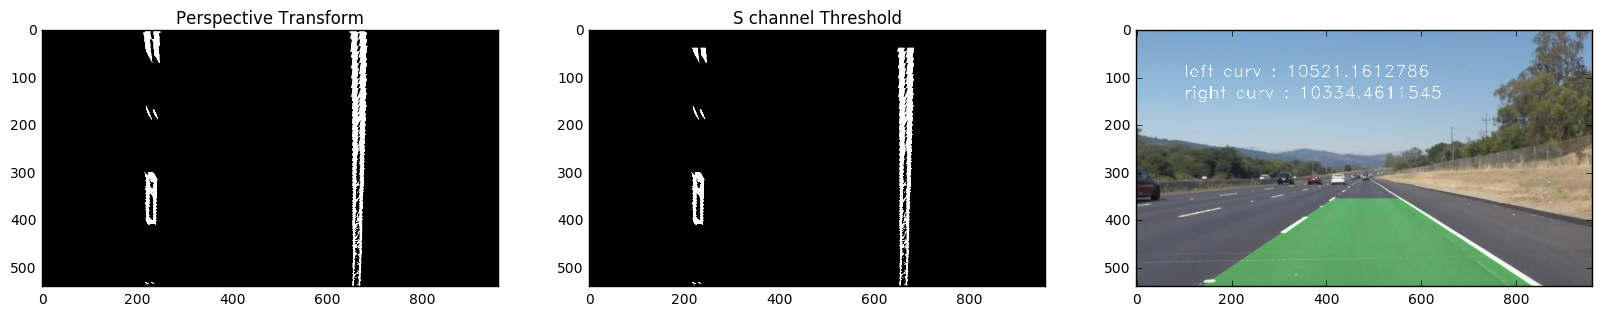

218 658


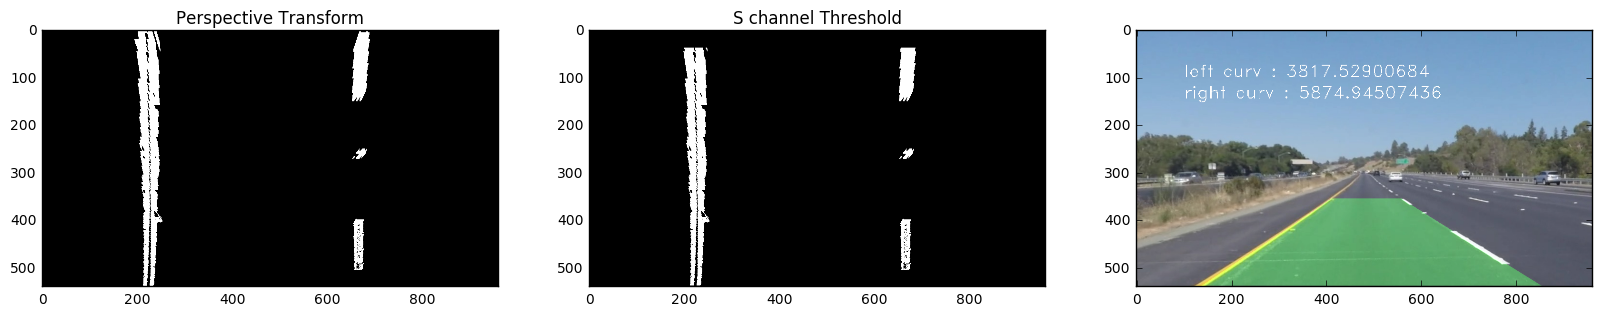

352 897


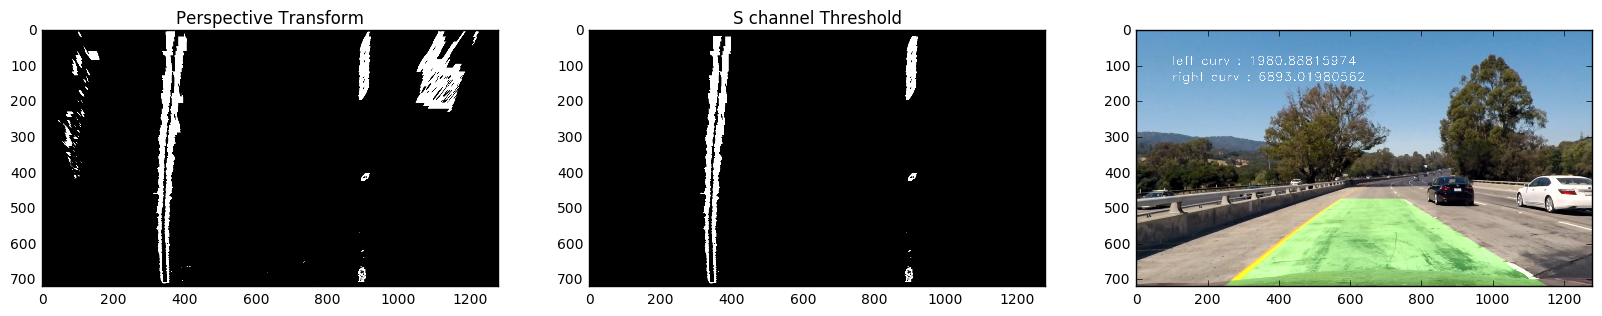

385 893


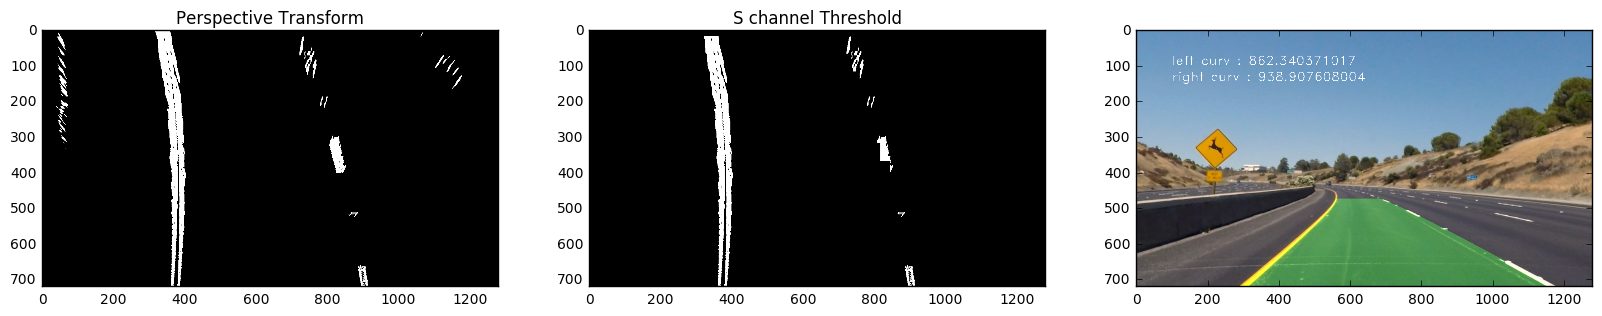

392 874


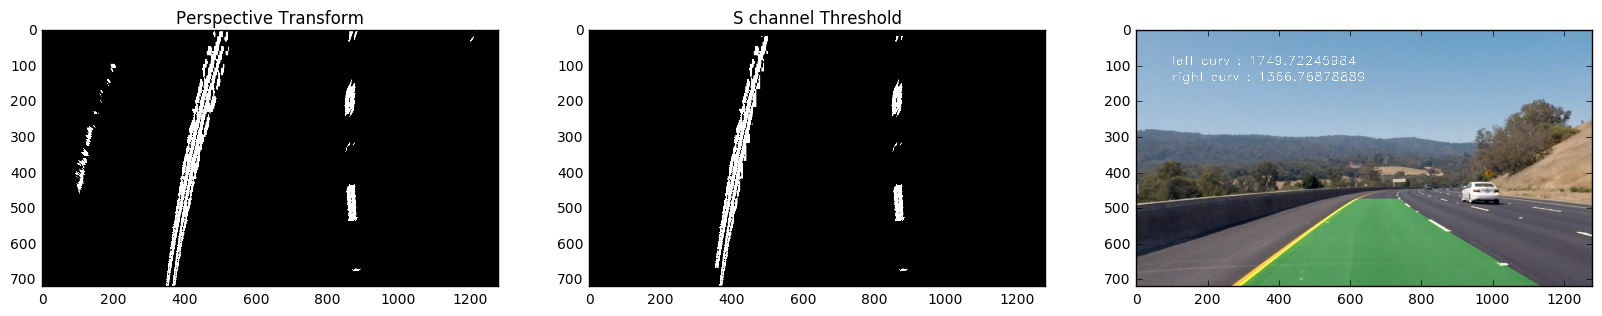

349 902


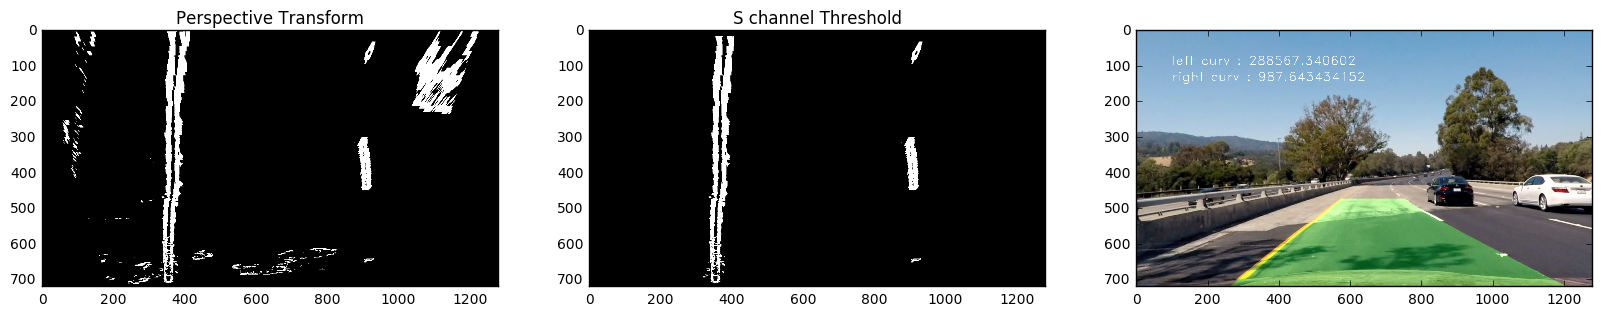

288 891


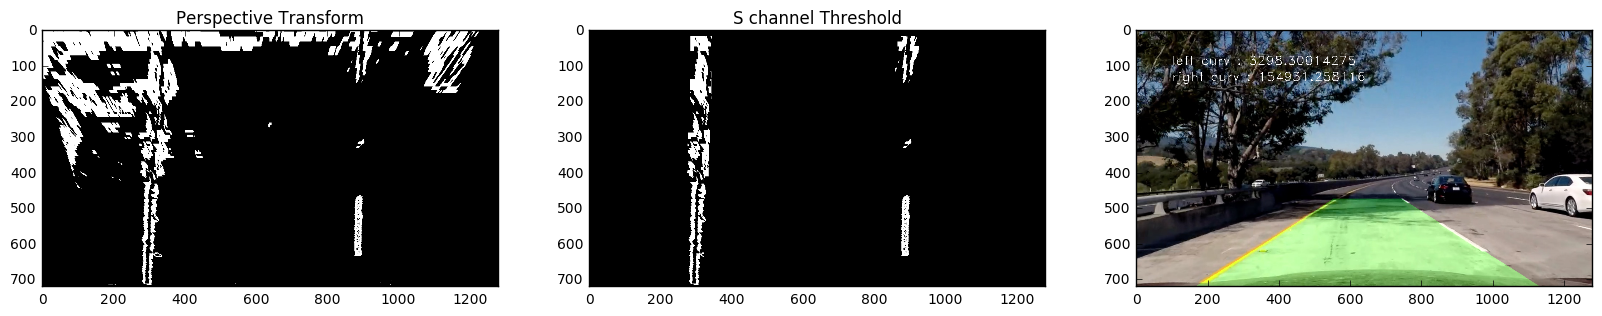

360 905


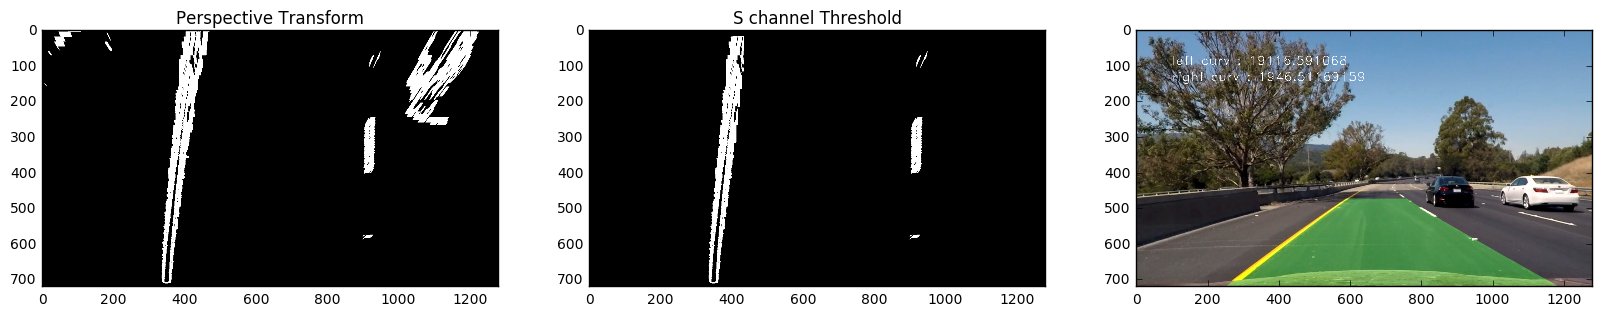

345 893


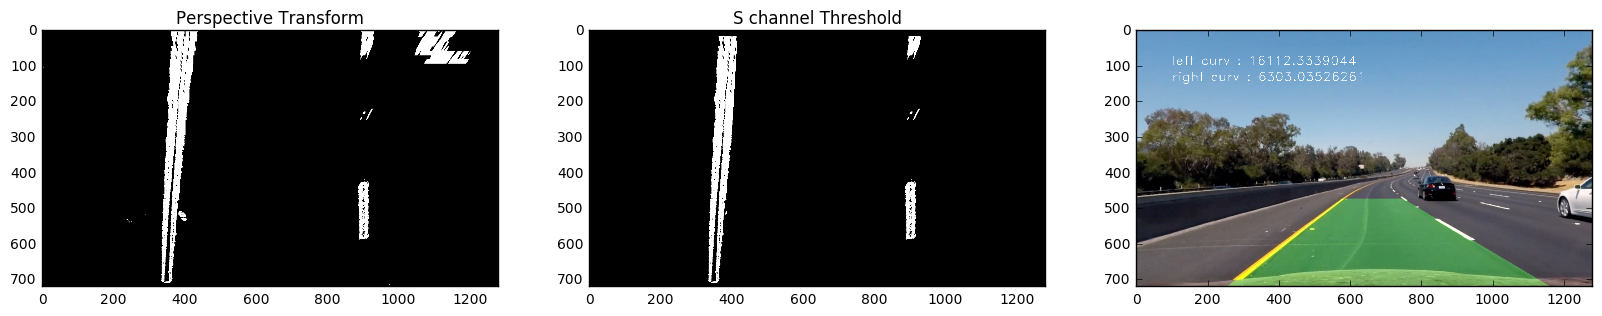

357 905


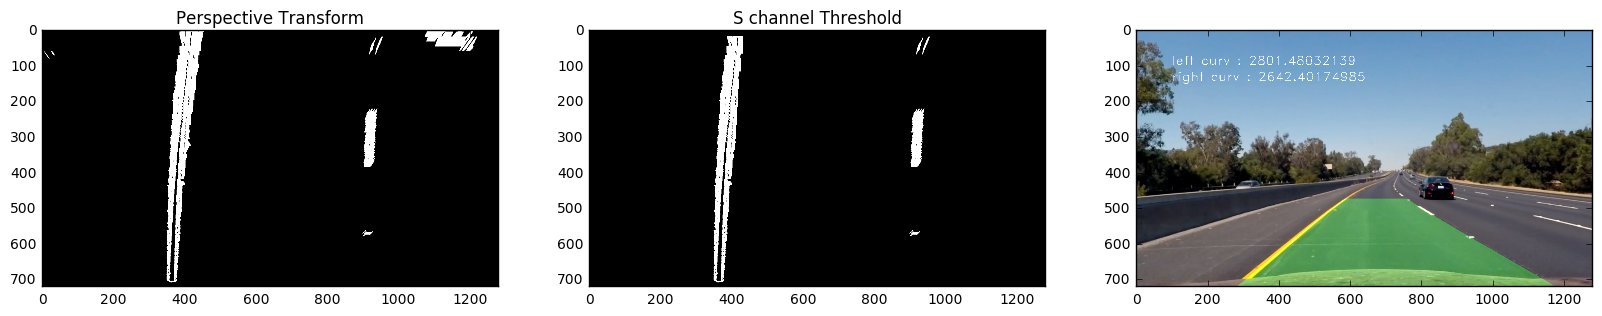

310 892


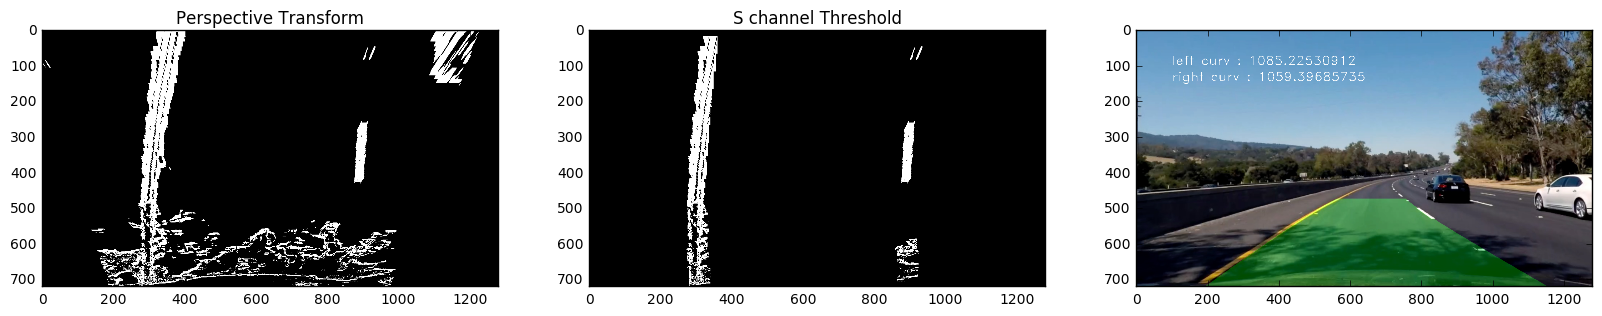

291 872


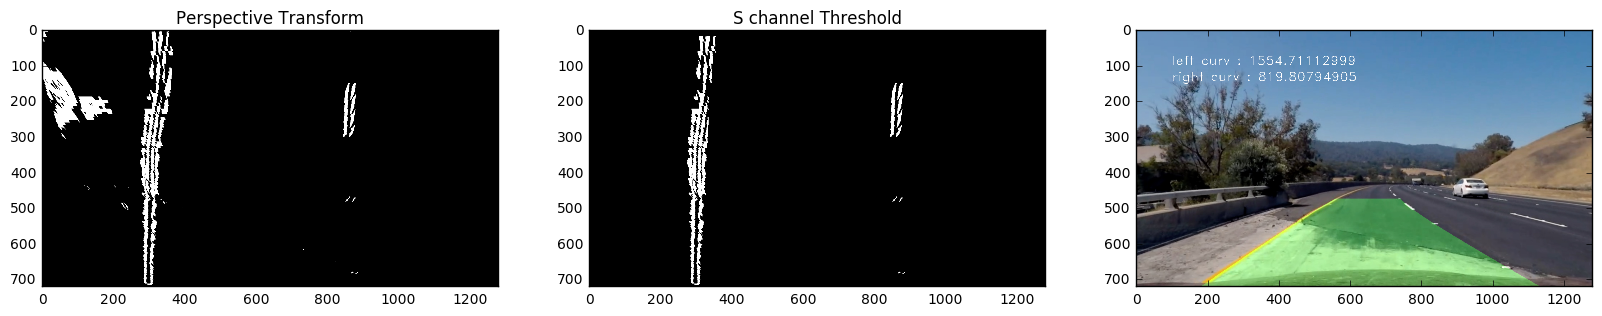

320 919


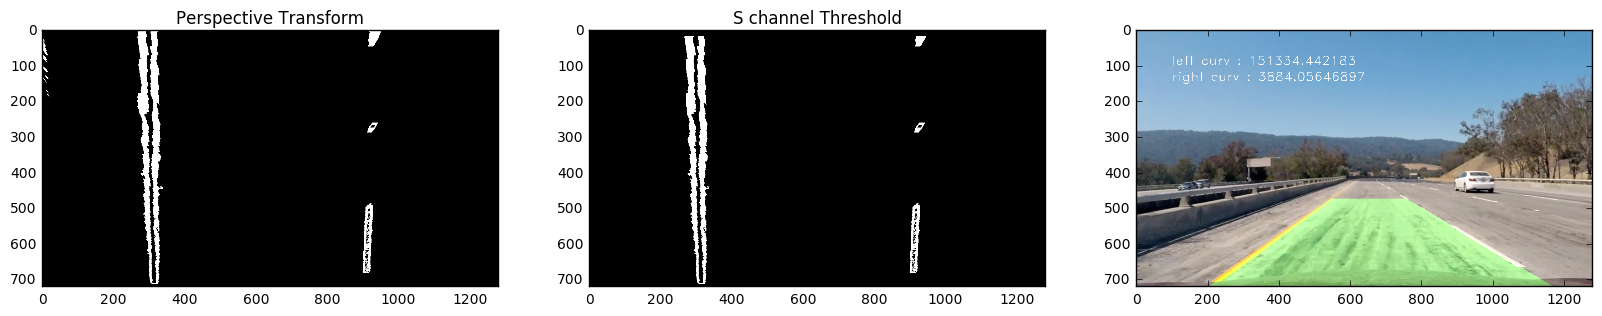

In [74]:
test_files = glob.glob('../test_images/*.jpg')

for file in test_files:
    f,(ax1,ax2,ax3) = plt.subplots(1,3,figsize = (20,10))
    imgRGB = cv2.imread(file)
    imgRGB = cv2.undistort(imgRGB,mtx,dist)
    imshape = imgRGB.shape
    p1 = (0,imshape[0])
    p2 = (int(0.5*imshape[1]),int(0.5*imshape[0]))
    p3 = (int(0.51*imshape[1]),int(0.5*imshape[0]))
    p4 = (imshape[1],imshape[0])
    vertices = np.array([[p1,p2, p3,p4]], dtype=np.int32) 
    imgHLS = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2HLS)
    imgGray = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2GRAY)
    masked_img = region_of_interest(imgGray,vertices)
    #RChannel = imgRGB[:,:,2]
    SChannel = imgHLS[:,:,2]
  
    #sBinary = thresh_color(SChannel,SThresh)
    sBinary_gradient,sTheta = thresh_gradient(SChannel,kernel = 3 ,threshold = (25,255))
    binary_gradient,theta = thresh_gradient(imgGray,kernel = 3 ,threshold = GThresh,angle = 1.2 )
    merged_binary = np.zeros_like(binary_gradient)
    
   # sBinary_gradient [ sTheta > 1 ] = 0
#     sBinary [ sTheta > 1 ] = 0
    merged_binary [(binary_gradient ==1) | (sBinary_gradient == 1)] = 1
    #merged_binary &= masked_img[:,:,0]
    merged_binary  = np.bitwise_and(merged_binary,masked_img)
    perTransform,M,Minv = perspective_transform(merged_binary)
    dict = find_lane_pixels(perTransform)
    rightX = dict['rightX']
    rightY = dict['rightY']
    leftY = dict['leftY']
    leftX = dict['leftX']
    leftX = [i for list in leftX for i in list]
    leftY = [i for list in leftY for i in list] 
    rightX = [i for list in rightX for i in list]
    rightY = [i for list in rightY for i in list]
    leftLane = Line(buffer_size = 5)
    rightLane = Line(buffer_size = 5)
    lane_pixels = np.zeros(imshape[:2])
    lane_pixels[leftY,leftX] = 255
    lane_pixels[rightY,rightX] = 255
    Lanes,left_curverad,right_curverad = fit_lanes(dict,imshape)
    Lanes = cv2.warpPerspective(Lanes,Minv,(imshape[1],imshape[0]))
    image = cv2.cvtColor(imgRGB,cv2.COLOR_BGR2RGB)
    final_out = cv2.addWeighted(image, 1, Lanes, 0.3, 0)
    cv2.putText(final_out,"left curv : " + str(left_curverad),(100,100), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    cv2.putText(final_out,"right curv : " + str(right_curverad),(100,145), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    

    
    ax1.imshow(perTransform,cmap = 'gray')
    ax2.imshow(lane_pixels,cmap = 'gray')
    ax3.imshow(final_out)
    ax1.set_title('Perspective Transform')
    ax2.set_title('S channel Threshold')
    plt.show()

In [75]:
leftLane = Line(buffer_size = 10)
rightLane = Line(buffer_size = 10)
def process_image(img):
    imgRGB=img
    imgRGB = cv2.undistort(imgRGB,mtx,dist)
    imshape = imgRGB.shape
    p1 = (0,imshape[0])
    p2 = (int(0.5*imshape[1]),int(0.5*imshape[0]))
    p3 = (int(0.51*imshape[1]),int(0.5*imshape[0]))
    p4 = (imshape[1],imshape[0])
    vertices = np.array([[p1,p2, p3,p4]], dtype=np.int32) 
    imgHLS = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2HLS)
    imgGray = cv2.cvtColor(imgRGB,cv2.COLOR_RGB2GRAY)
    masked_img = region_of_interest(imgGray,vertices)
    #RChannel = imgRGB[:,:,2]
    SChannel = imgHLS[:,:,2]
     
    sBinary_gradient,sTheta = thresh_gradient(SChannel,kernel = 3 ,threshold = (25,255))
    binary_gradient,_ = thresh_gradient(imgGray,kernel = 3 ,threshold = GThresh)
    merged_binary = np.zeros_like(binary_gradient)
    merged_binary [(binary_gradient ==1) | (sBinary_gradient ==1)] = 1
    
    merged_binary  = np.bitwise_and(merged_binary,masked_img)
    perTransform,M,Minv = perspective_transform(merged_binary)
    dict = find_lane_pixels(perTransform)
    Lanes,left_curverad,right_curverad = fit_lanes(dict,imshape)
    Lanes = cv2.warpPerspective(Lanes,Minv,(imshape[1],imshape[0]))
    final_out = cv2.addWeighted(img, 1, Lanes, 0.3, 0)
    cv2.putText(final_out,"left curv : " + str(left_curverad),(100,100), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    cv2.putText(final_out,"right curv : " + str(right_curverad),(100,145), cv2.FONT_HERSHEY_DUPLEX, 1.2, (255,255,255))
    return final_out

In [76]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
out_video = 'out.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(out_video, audio=False)

356 898
[MoviePy] >>>> Building video out.mp4
[MoviePy] Writing video out.mp4


  0%|          | 1/1261 [00:00<05:53,  3.57it/s]

356 898


  0%|          | 2/1261 [00:00<05:47,  3.63it/s]

357 903


  0%|          | 3/1261 [00:00<05:38,  3.72it/s]

372 905


  0%|          | 4/1261 [00:01<05:41,  3.68it/s]

358 919


  0%|          | 5/1261 [00:01<05:47,  3.61it/s]

374 923


  0%|          | 6/1261 [00:01<05:49,  3.59it/s]

375 910


  1%|          | 7/1261 [00:01<05:46,  3.62it/s]

375 910


  1%|          | 8/1261 [00:02<05:38,  3.71it/s]

377 904


  1%|          | 9/1261 [00:02<05:44,  3.64it/s]

378 875


  1%|          | 10/1261 [00:02<06:06,  3.42it/s]

377 880


  1%|          | 11/1261 [00:03<06:14,  3.34it/s]

376 894


  1%|          | 12/1261 [00:03<06:36,  3.15it/s]

374 893


  1%|          | 13/1261 [00:03<06:54,  3.01it/s]

379 896


  1%|          | 14/1261 [00:04<06:25,  3.23it/s]

376 899


  1%|          | 15/1261 [00:04<06:16,  3.31it/s]

377 905


  1%|▏         | 16/1261 [00:04<05:58,  3.47it/s]

358 903


  1%|▏         | 17/1261 [00:04<05:47,  3.58it/s]

375 904


  1%|▏         | 18/1261 [00:05<05:42,  3.63it/s]

378 915


  2%|▏         | 19/1261 [00:05<05:38,  3.67it/s]

374 905


  2%|▏         | 20/1261 [00:05<05:32,  3.73it/s]

372 906


  2%|▏         | 21/1261 [00:05<05:28,  3.77it/s]

372 891


  2%|▏         | 22/1261 [00:06<05:26,  3.79it/s]

371 868


  2%|▏         | 23/1261 [00:06<05:22,  3.84it/s]

370 874


  2%|▏         | 24/1261 [00:06<05:22,  3.84it/s]

367 877


  2%|▏         | 25/1261 [00:06<05:20,  3.85it/s]

367 882


  2%|▏         | 26/1261 [00:07<05:17,  3.89it/s]

366 889


  2%|▏         | 27/1261 [00:07<05:15,  3.91it/s]

365 895


  2%|▏         | 28/1261 [00:07<05:15,  3.91it/s]

363 911


  2%|▏         | 29/1261 [00:07<05:14,  3.92it/s]

363 914


  2%|▏         | 30/1261 [00:08<05:21,  3.82it/s]

362 915


  2%|▏         | 31/1261 [00:08<05:29,  3.73it/s]

361 903


  3%|▎         | 32/1261 [00:08<05:48,  3.52it/s]

362 904


  3%|▎         | 33/1261 [00:09<05:42,  3.59it/s]

360 904


  3%|▎         | 34/1261 [00:09<05:36,  3.65it/s]

362 896


  3%|▎         | 35/1261 [00:09<05:40,  3.60it/s]

363 872


  3%|▎         | 36/1261 [00:09<05:39,  3.61it/s]

364 875


  3%|▎         | 37/1261 [00:10<05:38,  3.62it/s]

351 882


  3%|▎         | 38/1261 [00:10<05:39,  3.61it/s]

367 884


  3%|▎         | 39/1261 [00:10<05:36,  3.63it/s]

367 888


  3%|▎         | 40/1261 [00:11<05:32,  3.67it/s]

367 891


  3%|▎         | 41/1261 [00:11<05:27,  3.72it/s]

367 897


  3%|▎         | 42/1261 [00:11<05:22,  3.78it/s]

354 903


  3%|▎         | 43/1261 [00:11<05:35,  3.63it/s]

355 912


  3%|▎         | 44/1261 [00:12<05:30,  3.68it/s]

368 903


  4%|▎         | 45/1261 [00:12<05:30,  3.68it/s]

373 905


  4%|▎         | 46/1261 [00:12<05:29,  3.68it/s]

369 893


  4%|▎         | 47/1261 [00:12<05:29,  3.69it/s]

372 868


  4%|▍         | 48/1261 [00:13<05:31,  3.66it/s]

370 873


  4%|▍         | 49/1261 [00:13<05:32,  3.64it/s]

372 884


  4%|▍         | 50/1261 [00:13<05:38,  3.58it/s]

368 885


  4%|▍         | 51/1261 [00:14<05:37,  3.59it/s]

369 894


  4%|▍         | 52/1261 [00:14<05:43,  3.51it/s]

370 897


  4%|▍         | 53/1261 [00:14<05:40,  3.55it/s]

369 898


  4%|▍         | 54/1261 [00:14<05:42,  3.52it/s]

371 900


  4%|▍         | 55/1261 [00:15<05:41,  3.53it/s]

369 911


  4%|▍         | 56/1261 [00:15<05:47,  3.47it/s]

368 914


  5%|▍         | 57/1261 [00:15<05:41,  3.52it/s]

368 902


  5%|▍         | 58/1261 [00:16<05:42,  3.51it/s]

367 902


  5%|▍         | 59/1261 [00:16<05:36,  3.57it/s]

367 857


  5%|▍         | 60/1261 [00:16<05:37,  3.55it/s]

367 869


  5%|▍         | 61/1261 [00:16<05:48,  3.44it/s]

367 874


  5%|▍         | 62/1261 [00:17<05:46,  3.46it/s]

367 869


  5%|▍         | 63/1261 [00:17<05:39,  3.53it/s]

366 874


  5%|▌         | 64/1261 [00:17<05:44,  3.47it/s]

365 878


  5%|▌         | 65/1261 [00:18<05:46,  3.45it/s]

363 884


  5%|▌         | 66/1261 [00:18<05:55,  3.36it/s]

363 888


  5%|▌         | 67/1261 [00:18<05:54,  3.37it/s]

361 892


  5%|▌         | 68/1261 [00:18<05:47,  3.43it/s]

363 899


  5%|▌         | 69/1261 [00:19<05:39,  3.51it/s]

344 903


  6%|▌         | 70/1261 [00:19<05:37,  3.53it/s]

357 890


  6%|▌         | 71/1261 [00:19<05:30,  3.60it/s]

357 875


  6%|▌         | 72/1261 [00:20<05:36,  3.54it/s]

341 846


  6%|▌         | 73/1261 [00:20<05:32,  3.57it/s]

341 851


  6%|▌         | 74/1261 [00:20<05:33,  3.55it/s]

339 868


  6%|▌         | 75/1261 [00:20<05:31,  3.58it/s]

358 862


  6%|▌         | 76/1261 [00:21<05:34,  3.54it/s]

354 866


  6%|▌         | 77/1261 [00:21<05:30,  3.59it/s]

352 877


  6%|▌         | 78/1261 [00:21<05:43,  3.44it/s]

351 883


  6%|▋         | 79/1261 [00:22<05:35,  3.52it/s]

351 882


  6%|▋         | 80/1261 [00:22<05:33,  3.54it/s]

350 884


  6%|▋         | 81/1261 [00:22<05:29,  3.58it/s]

350 883


  7%|▋         | 82/1261 [00:22<05:30,  3.57it/s]

348 884


  7%|▋         | 83/1261 [00:23<05:29,  3.57it/s]

347 886


  7%|▋         | 84/1261 [00:23<05:28,  3.59it/s]

344 879


  7%|▋         | 85/1261 [00:23<05:25,  3.61it/s]

343 857


  7%|▋         | 86/1261 [00:23<05:24,  3.62it/s]

343 862


  7%|▋         | 87/1261 [00:24<05:23,  3.63it/s]

346 868


  7%|▋         | 88/1261 [00:24<05:35,  3.50it/s]

328 865


  7%|▋         | 89/1261 [00:24<05:30,  3.55it/s]

343 868


  7%|▋         | 90/1261 [00:25<05:27,  3.58it/s]

344 872


  7%|▋         | 91/1261 [00:25<05:35,  3.49it/s]

344 876


  7%|▋         | 92/1261 [00:25<05:41,  3.42it/s]

345 880


  7%|▋         | 93/1261 [00:26<05:40,  3.43it/s]

345 893


  7%|▋         | 94/1261 [00:26<05:37,  3.45it/s]

347 895


  8%|▊         | 95/1261 [00:26<05:34,  3.49it/s]

347 881


  8%|▊         | 96/1261 [00:26<05:35,  3.47it/s]

347 877


  8%|▊         | 97/1261 [00:27<05:35,  3.47it/s]

348 844


  8%|▊         | 98/1261 [00:27<05:31,  3.51it/s]

333 851


  8%|▊         | 99/1261 [00:27<05:29,  3.52it/s]

349 864


  8%|▊         | 100/1261 [00:28<05:28,  3.54it/s]

335 859


  8%|▊         | 101/1261 [00:28<05:23,  3.59it/s]

336 865


  8%|▊         | 102/1261 [00:28<05:22,  3.59it/s]

337 871


  8%|▊         | 103/1261 [00:28<05:20,  3.61it/s]

352 881


  8%|▊         | 104/1261 [00:29<05:22,  3.58it/s]

353 884


  8%|▊         | 105/1261 [00:29<05:19,  3.62it/s]

353 880


  8%|▊         | 106/1261 [00:29<05:20,  3.60it/s]

353 883


  8%|▊         | 107/1261 [00:29<05:27,  3.53it/s]

339 886


  9%|▊         | 108/1261 [00:30<05:20,  3.60it/s]

354 888


  9%|▊         | 109/1261 [00:30<05:22,  3.57it/s]

355 888


  9%|▊         | 110/1261 [00:30<05:17,  3.62it/s]

355 879


  9%|▉         | 111/1261 [00:31<05:18,  3.61it/s]

356 882


  9%|▉         | 112/1261 [00:31<05:15,  3.65it/s]

341 875


  9%|▉         | 113/1261 [00:31<05:17,  3.62it/s]

343 876


  9%|▉         | 114/1261 [00:31<05:16,  3.62it/s]

344 880


  9%|▉         | 115/1261 [00:32<05:22,  3.55it/s]

345 890


  9%|▉         | 116/1261 [00:32<05:19,  3.58it/s]

345 889


  9%|▉         | 117/1261 [00:32<05:20,  3.57it/s]

360 899


  9%|▉         | 118/1261 [00:33<05:20,  3.56it/s]

346 902


  9%|▉         | 119/1261 [00:33<05:27,  3.48it/s]

362 892


 10%|▉         | 120/1261 [00:33<05:29,  3.46it/s]

349 893


 10%|▉         | 121/1261 [00:33<05:29,  3.46it/s]

365 894


 10%|▉         | 122/1261 [00:34<05:26,  3.49it/s]

366 888


 10%|▉         | 123/1261 [00:34<06:02,  3.14it/s]

351 865


 10%|▉         | 124/1261 [00:34<05:54,  3.21it/s]

367 867


 10%|▉         | 125/1261 [00:35<05:51,  3.23it/s]

369 873


 10%|▉         | 126/1261 [00:35<06:12,  3.05it/s]

353 879


 10%|█         | 127/1261 [00:35<05:57,  3.17it/s]

351 887


 10%|█         | 128/1261 [00:36<05:51,  3.23it/s]

369 889


 10%|█         | 129/1261 [00:36<05:46,  3.27it/s]

371 891


 10%|█         | 130/1261 [00:36<05:37,  3.36it/s]

357 895


 10%|█         | 131/1261 [00:36<05:31,  3.41it/s]

371 897


 10%|█         | 132/1261 [00:37<05:53,  3.19it/s]

357 898


 11%|█         | 133/1261 [00:37<05:45,  3.27it/s]

373 900


 11%|█         | 134/1261 [00:37<05:35,  3.36it/s]

360 895


 11%|█         | 135/1261 [00:38<05:28,  3.43it/s]

361 867


 11%|█         | 136/1261 [00:38<05:23,  3.48it/s]

376 872


 11%|█         | 137/1261 [00:38<05:19,  3.52it/s]

375 879


 11%|█         | 138/1261 [00:39<05:13,  3.59it/s]

374 889


 11%|█         | 139/1261 [00:39<05:11,  3.60it/s]

373 890


 11%|█         | 140/1261 [00:39<05:12,  3.59it/s]

372 896


 11%|█         | 141/1261 [00:39<05:14,  3.57it/s]

372 904


 11%|█▏        | 142/1261 [00:40<05:11,  3.59it/s]

372 904


 11%|█▏        | 143/1261 [00:40<05:09,  3.61it/s]

372 909


 11%|█▏        | 144/1261 [00:40<05:10,  3.59it/s]

371 902


 11%|█▏        | 145/1261 [00:40<05:23,  3.45it/s]

370 904


 12%|█▏        | 146/1261 [00:41<05:22,  3.46it/s]

370 904


 12%|█▏        | 147/1261 [00:41<05:19,  3.49it/s]

373 903


 12%|█▏        | 148/1261 [00:41<05:39,  3.27it/s]

371 865


 12%|█▏        | 149/1261 [00:42<05:54,  3.14it/s]

372 877


 12%|█▏        | 150/1261 [00:42<06:08,  3.02it/s]

372 881


 12%|█▏        | 151/1261 [00:42<06:19,  2.93it/s]

371 882


 12%|█▏        | 152/1261 [00:43<05:56,  3.11it/s]

370 890


 12%|█▏        | 153/1261 [00:43<05:52,  3.15it/s]

372 892


 12%|█▏        | 154/1261 [00:43<05:39,  3.26it/s]

371 897


 12%|█▏        | 155/1261 [00:44<05:32,  3.32it/s]

369 909


 12%|█▏        | 156/1261 [00:44<05:26,  3.38it/s]

371 911


 12%|█▏        | 157/1261 [00:44<05:19,  3.45it/s]

371 900


 13%|█▎        | 158/1261 [00:44<05:11,  3.54it/s]

371 898


 13%|█▎        | 159/1261 [00:45<05:11,  3.53it/s]

369 885


 13%|█▎        | 160/1261 [00:45<05:10,  3.54it/s]

346 864


 13%|█▎        | 161/1261 [00:45<05:10,  3.54it/s]

366 870


 13%|█▎        | 162/1261 [00:46<05:04,  3.61it/s]

365 879


 13%|█▎        | 163/1261 [00:46<05:03,  3.62it/s]

360 887


 13%|█▎        | 164/1261 [00:46<05:04,  3.60it/s]

360 884


 13%|█▎        | 165/1261 [00:46<05:06,  3.57it/s]

345 886


 13%|█▎        | 166/1261 [00:47<05:02,  3.62it/s]

343 895


 13%|█▎        | 167/1261 [00:47<05:05,  3.58it/s]

361 897


 13%|█▎        | 168/1261 [00:47<05:05,  3.58it/s]

363 900


 13%|█▎        | 169/1261 [00:48<05:05,  3.57it/s]

362 910


 13%|█▎        | 170/1261 [00:48<05:05,  3.57it/s]

360 912


 14%|█▎        | 171/1261 [00:48<05:15,  3.46it/s]

359 881


 14%|█▎        | 172/1261 [00:48<05:13,  3.47it/s]

358 884


 14%|█▎        | 173/1261 [00:49<05:12,  3.49it/s]

358 869


 14%|█▍        | 174/1261 [00:49<05:05,  3.56it/s]

358 866


 14%|█▍        | 175/1261 [00:49<05:03,  3.58it/s]

359 865


 14%|█▍        | 176/1261 [00:50<05:03,  3.57it/s]

358 871


 14%|█▍        | 177/1261 [00:50<05:13,  3.45it/s]

354 877


 14%|█▍        | 178/1261 [00:50<05:06,  3.53it/s]

352 884


 14%|█▍        | 179/1261 [00:50<05:06,  3.53it/s]

354 897


 14%|█▍        | 180/1261 [00:51<05:20,  3.37it/s]

352 905


 14%|█▍        | 181/1261 [00:51<05:45,  3.12it/s]

352 893


 14%|█▍        | 182/1261 [00:51<05:53,  3.06it/s]

350 896


 15%|█▍        | 183/1261 [00:52<06:00,  2.99it/s]

350 898


 15%|█▍        | 184/1261 [00:52<05:41,  3.15it/s]

354 888


 15%|█▍        | 185/1261 [00:52<05:27,  3.29it/s]

336 865


 15%|█▍        | 186/1261 [00:53<05:15,  3.41it/s]

352 868


 15%|█▍        | 187/1261 [00:53<05:10,  3.46it/s]

353 873


 15%|█▍        | 188/1261 [00:53<05:03,  3.54it/s]

338 876


 15%|█▍        | 189/1261 [00:53<05:00,  3.57it/s]

339 881


 15%|█▌        | 190/1261 [00:54<04:58,  3.58it/s]

340 888


 15%|█▌        | 191/1261 [00:54<05:10,  3.44it/s]

342 891


 15%|█▌        | 192/1261 [00:54<05:03,  3.52it/s]

362 899


 15%|█▌        | 193/1261 [00:55<04:58,  3.58it/s]

346 906


 15%|█▌        | 194/1261 [00:55<04:58,  3.57it/s]

348 897


 15%|█▌        | 195/1261 [00:55<05:01,  3.54it/s]

351 898


 16%|█▌        | 196/1261 [00:55<05:01,  3.53it/s]

368 884


 16%|█▌        | 197/1261 [00:56<05:05,  3.48it/s]

364 866


 16%|█▌        | 198/1261 [00:56<05:04,  3.49it/s]

361 875


 16%|█▌        | 199/1261 [00:56<05:04,  3.49it/s]

355 885


 16%|█▌        | 200/1261 [00:57<05:04,  3.48it/s]

356 887


 16%|█▌        | 201/1261 [00:57<05:05,  3.47it/s]

354 892


 16%|█▌        | 202/1261 [00:57<04:57,  3.55it/s]

355 894


 16%|█▌        | 203/1261 [00:57<05:04,  3.48it/s]

334 896


 16%|█▌        | 204/1261 [00:58<04:57,  3.56it/s]

354 901


 16%|█▋        | 205/1261 [00:58<05:00,  3.52it/s]

356 899


 16%|█▋        | 206/1261 [00:58<04:58,  3.54it/s]

356 911


 16%|█▋        | 207/1261 [00:59<05:03,  3.47it/s]

338 898


 16%|█▋        | 208/1261 [00:59<05:10,  3.39it/s]

339 879


 17%|█▋        | 209/1261 [00:59<05:21,  3.27it/s]

339 855


 17%|█▋        | 210/1261 [00:59<05:08,  3.40it/s]

359 862


 17%|█▋        | 211/1261 [01:00<05:06,  3.43it/s]

357 875


 17%|█▋        | 212/1261 [01:00<04:58,  3.51it/s]

357 880


 17%|█▋        | 213/1261 [01:00<04:55,  3.54it/s]

358 881


 17%|█▋        | 214/1261 [01:01<04:56,  3.53it/s]

357 886


 17%|█▋        | 215/1261 [01:01<04:57,  3.52it/s]

356 887


 17%|█▋        | 216/1261 [01:01<04:51,  3.59it/s]

336 893


 17%|█▋        | 217/1261 [01:01<04:52,  3.57it/s]

351 895


 17%|█▋        | 218/1261 [01:02<04:50,  3.59it/s]

333 903


 17%|█▋        | 219/1261 [01:02<04:50,  3.59it/s]

349 905


 17%|█▋        | 220/1261 [01:02<04:47,  3.62it/s]

354 890


 18%|█▊        | 221/1261 [01:03<04:48,  3.61it/s]

331 877


 18%|█▊        | 222/1261 [01:03<04:49,  3.59it/s]

350 864


 18%|█▊        | 223/1261 [01:03<05:04,  3.41it/s]

351 864


 18%|█▊        | 224/1261 [01:03<05:01,  3.44it/s]

351 862


 18%|█▊        | 225/1261 [01:04<05:03,  3.41it/s]

352 867


 18%|█▊        | 226/1261 [01:04<05:03,  3.41it/s]

355 871


 18%|█▊        | 227/1261 [01:04<05:06,  3.37it/s]

353 876


 18%|█▊        | 228/1261 [01:05<04:59,  3.44it/s]

351 880


 18%|█▊        | 229/1261 [01:05<04:57,  3.47it/s]

347 885


 18%|█▊        | 230/1261 [01:05<04:55,  3.49it/s]

345 882


 18%|█▊        | 231/1261 [01:05<04:54,  3.50it/s]

344 892


 18%|█▊        | 232/1261 [01:06<04:48,  3.57it/s]

343 878


 18%|█▊        | 233/1261 [01:06<04:47,  3.58it/s]

342 865


 19%|█▊        | 234/1261 [01:06<04:44,  3.61it/s]

341 840


 19%|█▊        | 235/1261 [01:07<04:41,  3.65it/s]

340 844


 19%|█▊        | 236/1261 [01:07<04:39,  3.67it/s]

342 846


 19%|█▉        | 237/1261 [01:07<04:39,  3.66it/s]

340 852


 19%|█▉        | 238/1261 [01:07<04:39,  3.66it/s]

337 857


 19%|█▉        | 239/1261 [01:08<04:38,  3.66it/s]

340 861


 19%|█▉        | 240/1261 [01:08<04:39,  3.65it/s]

339 866


 19%|█▉        | 241/1261 [01:08<04:43,  3.60it/s]

336 870


 19%|█▉        | 242/1261 [01:08<04:43,  3.59it/s]

335 883


 19%|█▉        | 243/1261 [01:09<04:44,  3.58it/s]

338 884


 19%|█▉        | 244/1261 [01:09<04:40,  3.62it/s]

336 871


 19%|█▉        | 245/1261 [01:09<04:45,  3.56it/s]

336 858


 20%|█▉        | 246/1261 [01:10<04:43,  3.58it/s]

316 831


 20%|█▉        | 247/1261 [01:10<04:41,  3.60it/s]

315 845


 20%|█▉        | 248/1261 [01:10<04:38,  3.63it/s]

316 844


 20%|█▉        | 249/1261 [01:10<04:41,  3.60it/s]

316 850


 20%|█▉        | 250/1261 [01:11<04:41,  3.59it/s]

329 852


 20%|█▉        | 251/1261 [01:11<04:48,  3.50it/s]

313 861


 20%|█▉        | 252/1261 [01:11<04:47,  3.51it/s]

313 863


 20%|██        | 253/1261 [01:12<04:46,  3.52it/s]

314 868


 20%|██        | 254/1261 [01:12<04:46,  3.52it/s]

334 880


 20%|██        | 255/1261 [01:12<04:44,  3.54it/s]

316 868


 20%|██        | 256/1261 [01:12<04:43,  3.55it/s]

315 870


 20%|██        | 257/1261 [01:13<04:39,  3.59it/s]

331 868


 20%|██        | 258/1261 [01:13<04:38,  3.60it/s]

332 843


 21%|██        | 259/1261 [01:13<04:35,  3.64it/s]

330 847


 21%|██        | 260/1261 [01:13<04:35,  3.64it/s]

332 851


 21%|██        | 261/1261 [01:14<04:34,  3.65it/s]

318 858


 21%|██        | 262/1261 [01:14<04:45,  3.50it/s]

333 859


 21%|██        | 263/1261 [01:14<04:42,  3.53it/s]

333 859


 21%|██        | 264/1261 [01:15<04:41,  3.54it/s]

334 872


 21%|██        | 265/1261 [01:15<04:37,  3.59it/s]

333 876


 21%|██        | 266/1261 [01:15<04:39,  3.56it/s]

332 873


 21%|██        | 267/1261 [01:15<04:39,  3.56it/s]

332 875


 21%|██▏       | 268/1261 [01:16<04:39,  3.56it/s]

331 875


 21%|██▏       | 269/1261 [01:16<04:36,  3.59it/s]

329 877


 21%|██▏       | 270/1261 [01:16<04:37,  3.57it/s]

331 866


 21%|██▏       | 271/1261 [01:17<04:36,  3.59it/s]

317 871


 22%|██▏       | 272/1261 [01:17<04:33,  3.61it/s]

319 867


 22%|██▏       | 273/1261 [01:17<04:32,  3.63it/s]

320 860


 22%|██▏       | 274/1261 [01:17<04:33,  3.61it/s]

319 863


 22%|██▏       | 275/1261 [01:18<04:31,  3.63it/s]

319 870


 22%|██▏       | 276/1261 [01:18<04:33,  3.60it/s]

337 875


 22%|██▏       | 277/1261 [01:18<04:37,  3.54it/s]

323 880


 22%|██▏       | 278/1261 [01:19<04:42,  3.48it/s]

323 893


 22%|██▏       | 279/1261 [01:19<04:43,  3.46it/s]

324 881


 22%|██▏       | 280/1261 [01:19<04:38,  3.53it/s]

340 880


 22%|██▏       | 281/1261 [01:19<04:40,  3.49it/s]

342 877


 22%|██▏       | 282/1261 [01:20<04:35,  3.55it/s]

328 869


 22%|██▏       | 283/1261 [01:20<04:32,  3.59it/s]

328 874


 23%|██▎       | 284/1261 [01:20<04:28,  3.65it/s]

330 877


 23%|██▎       | 285/1261 [01:20<04:30,  3.61it/s]

345 871


 23%|██▎       | 286/1261 [01:21<04:27,  3.64it/s]

344 877


 23%|██▎       | 287/1261 [01:21<04:27,  3.64it/s]

345 891


 23%|██▎       | 288/1261 [01:21<04:27,  3.64it/s]

345 884


 23%|██▎       | 289/1261 [01:22<04:26,  3.65it/s]

333 898


 23%|██▎       | 290/1261 [01:22<04:28,  3.61it/s]

348 890


 23%|██▎       | 291/1261 [01:22<04:27,  3.63it/s]

351 890


 23%|██▎       | 292/1261 [01:22<04:26,  3.64it/s]

334 892


 23%|██▎       | 293/1261 [01:23<04:28,  3.61it/s]

353 881


 23%|██▎       | 294/1261 [01:23<04:28,  3.60it/s]

334 878


 23%|██▎       | 295/1261 [01:23<04:25,  3.63it/s]

339 881


 23%|██▎       | 296/1261 [01:24<04:25,  3.64it/s]

339 885


 24%|██▎       | 297/1261 [01:24<04:21,  3.68it/s]

353 876


 24%|██▎       | 298/1261 [01:24<04:27,  3.60it/s]

353 880


 24%|██▎       | 299/1261 [01:24<04:25,  3.62it/s]

352 884


 24%|██▍       | 300/1261 [01:25<04:23,  3.65it/s]

351 899


 24%|██▍       | 301/1261 [01:25<04:25,  3.62it/s]

351 888


 24%|██▍       | 302/1261 [01:25<04:28,  3.57it/s]

350 905


 24%|██▍       | 303/1261 [01:25<04:27,  3.58it/s]

349 894


 24%|██▍       | 304/1261 [01:26<04:33,  3.50it/s]

349 894


 24%|██▍       | 305/1261 [01:26<04:32,  3.51it/s]

348 891


 24%|██▍       | 306/1261 [01:26<04:38,  3.43it/s]

350 882


 24%|██▍       | 307/1261 [01:27<04:34,  3.47it/s]

336 889


 24%|██▍       | 308/1261 [01:27<04:34,  3.47it/s]

339 873


 25%|██▍       | 309/1261 [01:27<04:32,  3.49it/s]

339 878


 25%|██▍       | 310/1261 [01:27<04:29,  3.53it/s]

340 885


 25%|██▍       | 311/1261 [01:28<04:24,  3.59it/s]

341 886


 25%|██▍       | 312/1261 [01:28<04:22,  3.61it/s]

341 889


 25%|██▍       | 313/1261 [01:28<04:22,  3.62it/s]

344 891


 25%|██▍       | 314/1261 [01:29<04:21,  3.62it/s]

361 893


 25%|██▍       | 315/1261 [01:29<04:20,  3.63it/s]

345 892


 25%|██▌       | 316/1261 [01:29<04:20,  3.62it/s]

345 893


 25%|██▌       | 317/1261 [01:29<04:21,  3.61it/s]

362 882


 25%|██▌       | 318/1261 [01:30<04:23,  3.58it/s]

345 878


 25%|██▌       | 319/1261 [01:30<04:19,  3.62it/s]

345 884


 25%|██▌       | 320/1261 [01:30<04:19,  3.62it/s]

346 880


 25%|██▌       | 321/1261 [01:31<04:17,  3.65it/s]

346 877


 26%|██▌       | 322/1261 [01:31<04:19,  3.61it/s]

346 889


 26%|██▌       | 323/1261 [01:31<04:18,  3.63it/s]

347 892


 26%|██▌       | 324/1261 [01:31<04:20,  3.60it/s]

347 886


 26%|██▌       | 325/1261 [01:32<04:20,  3.59it/s]

347 900


 26%|██▌       | 326/1261 [01:32<04:23,  3.54it/s]

347 890


 26%|██▌       | 327/1261 [01:32<04:20,  3.58it/s]

346 891


 26%|██▌       | 328/1261 [01:32<04:21,  3.57it/s]

345 891


 26%|██▌       | 329/1261 [01:33<04:17,  3.62it/s]

342 891


 26%|██▌       | 330/1261 [01:33<04:19,  3.59it/s]

343 886


 26%|██▌       | 331/1261 [01:33<04:21,  3.56it/s]

343 888


 26%|██▋       | 332/1261 [01:34<04:31,  3.42it/s]

345 889


 26%|██▋       | 333/1261 [01:34<04:37,  3.35it/s]

344 889


 26%|██▋       | 334/1261 [01:34<04:34,  3.38it/s]

345 880


 27%|██▋       | 335/1261 [01:35<04:30,  3.42it/s]

345 884


 27%|██▋       | 336/1261 [01:35<04:29,  3.43it/s]

343 890


 27%|██▋       | 337/1261 [01:35<04:25,  3.48it/s]

344 893


 27%|██▋       | 338/1261 [01:35<04:23,  3.51it/s]

344 895


 27%|██▋       | 339/1261 [01:36<04:21,  3.53it/s]

345 896


 27%|██▋       | 340/1261 [01:36<04:18,  3.56it/s]

345 895


 27%|██▋       | 341/1261 [01:36<04:17,  3.58it/s]

346 897


 27%|██▋       | 342/1261 [01:36<04:18,  3.56it/s]

347 885


 27%|██▋       | 343/1261 [01:37<04:13,  3.62it/s]

347 888


 27%|██▋       | 344/1261 [01:37<04:15,  3.59it/s]

346 892


 27%|██▋       | 345/1261 [01:37<04:14,  3.60it/s]

346 894


 27%|██▋       | 346/1261 [01:38<04:16,  3.57it/s]

346 884


 28%|██▊       | 347/1261 [01:38<04:14,  3.60it/s]

347 885


 28%|██▊       | 348/1261 [01:38<04:12,  3.61it/s]

343 890


 28%|██▊       | 349/1261 [01:38<04:13,  3.60it/s]

348 905


 28%|██▊       | 350/1261 [01:39<04:15,  3.57it/s]

347 895


 28%|██▊       | 351/1261 [01:39<04:14,  3.58it/s]

347 895


 28%|██▊       | 352/1261 [01:39<04:14,  3.57it/s]

346 897


 28%|██▊       | 353/1261 [01:40<04:11,  3.62it/s]

345 902


 28%|██▊       | 354/1261 [01:40<04:12,  3.59it/s]

345 889


 28%|██▊       | 355/1261 [01:40<04:09,  3.63it/s]

340 892


 28%|██▊       | 356/1261 [01:40<04:16,  3.53it/s]

343 895


 28%|██▊       | 357/1261 [01:41<04:16,  3.52it/s]

345 895


 28%|██▊       | 358/1261 [01:41<04:33,  3.30it/s]

344 899


 28%|██▊       | 359/1261 [01:41<04:54,  3.06it/s]

346 886


 29%|██▊       | 360/1261 [01:42<05:08,  2.92it/s]

346 904


 29%|██▊       | 361/1261 [01:42<04:55,  3.04it/s]

346 907


 29%|██▊       | 362/1261 [01:42<04:54,  3.05it/s]

348 891


 29%|██▉       | 363/1261 [01:43<04:39,  3.21it/s]

349 892


 29%|██▉       | 364/1261 [01:43<04:51,  3.08it/s]

351 892


 29%|██▉       | 365/1261 [01:43<04:36,  3.24it/s]

350 898


 29%|██▉       | 366/1261 [01:44<04:38,  3.21it/s]

351 889


 29%|██▉       | 367/1261 [01:44<04:45,  3.13it/s]

351 891


 29%|██▉       | 368/1261 [01:44<04:32,  3.28it/s]

347 895


 29%|██▉       | 369/1261 [01:44<04:19,  3.44it/s]

367 894


 29%|██▉       | 370/1261 [01:45<04:14,  3.51it/s]

365 884


 29%|██▉       | 371/1261 [01:45<04:56,  3.00it/s]

364 887


 30%|██▉       | 372/1261 [01:46<05:21,  2.77it/s]

363 889


 30%|██▉       | 373/1261 [01:46<05:13,  2.83it/s]

347 892


 30%|██▉       | 374/1261 [01:46<05:50,  2.53it/s]

346 892


 30%|██▉       | 375/1261 [01:47<05:23,  2.74it/s]

344 892


 30%|██▉       | 376/1261 [01:47<05:08,  2.87it/s]

345 891


 30%|██▉       | 377/1261 [01:47<04:59,  2.95it/s]

343 885


 30%|██▉       | 378/1261 [01:48<05:28,  2.69it/s]

343 882


 30%|███       | 379/1261 [01:48<05:16,  2.79it/s]

341 885


 30%|███       | 380/1261 [01:48<04:58,  2.95it/s]

340 890


 30%|███       | 381/1261 [01:49<05:10,  2.84it/s]

340 894


 30%|███       | 382/1261 [01:49<04:59,  2.93it/s]

340 882


 30%|███       | 383/1261 [01:49<04:50,  3.03it/s]

341 884


 30%|███       | 384/1261 [01:50<04:47,  3.05it/s]

341 887


 31%|███       | 385/1261 [01:50<04:46,  3.05it/s]

341 889


 31%|███       | 386/1261 [01:51<05:25,  2.69it/s]

340 892


 31%|███       | 387/1261 [01:51<05:04,  2.87it/s]

340 894


 31%|███       | 388/1261 [01:51<04:47,  3.04it/s]

341 894


 31%|███       | 389/1261 [01:51<04:40,  3.10it/s]

341 896


 31%|███       | 390/1261 [01:52<04:29,  3.24it/s]

341 887


 31%|███       | 391/1261 [01:52<04:19,  3.35it/s]

340 892


 31%|███       | 392/1261 [01:52<04:11,  3.45it/s]

340 891


 31%|███       | 393/1261 [01:53<04:08,  3.50it/s]

340 891


 31%|███       | 394/1261 [01:53<04:12,  3.44it/s]

338 881


 31%|███▏      | 395/1261 [01:53<04:34,  3.15it/s]

342 882


 31%|███▏      | 396/1261 [01:54<04:29,  3.20it/s]

341 883


 31%|███▏      | 397/1261 [01:54<04:36,  3.12it/s]

354 886


 32%|███▏      | 398/1261 [01:54<04:45,  3.02it/s]

339 888


 32%|███▏      | 399/1261 [01:55<04:43,  3.04it/s]

338 889


 32%|███▏      | 400/1261 [01:55<04:28,  3.21it/s]

333 890


 32%|███▏      | 401/1261 [01:55<04:35,  3.12it/s]

332 892


 32%|███▏      | 402/1261 [01:56<04:59,  2.87it/s]

336 884


 32%|███▏      | 403/1261 [01:56<04:57,  2.88it/s]

336 884


 32%|███▏      | 404/1261 [01:56<05:15,  2.72it/s]

335 887


 32%|███▏      | 405/1261 [01:57<06:08,  2.32it/s]

335 888


 32%|███▏      | 406/1261 [01:57<06:14,  2.28it/s]

335 876


 32%|███▏      | 407/1261 [01:58<05:38,  2.53it/s]

334 878


 32%|███▏      | 408/1261 [01:58<05:11,  2.73it/s]

333 879


 32%|███▏      | 409/1261 [01:58<05:03,  2.81it/s]

347 896


 33%|███▎      | 410/1261 [01:59<04:54,  2.89it/s]

334 881


 33%|███▎      | 411/1261 [01:59<04:48,  2.95it/s]

346 882


 33%|███▎      | 412/1261 [01:59<04:41,  3.02it/s]

346 881


 33%|███▎      | 413/1261 [02:00<04:32,  3.11it/s]

345 881


 33%|███▎      | 414/1261 [02:00<04:25,  3.19it/s]

345 871


 33%|███▎      | 415/1261 [02:00<04:18,  3.28it/s]

329 876


 33%|███▎      | 416/1261 [02:01<04:33,  3.09it/s]

343 880


 33%|███▎      | 417/1261 [02:01<04:38,  3.03it/s]

343 880


 33%|███▎      | 418/1261 [02:01<04:24,  3.19it/s]

323 869


 33%|███▎      | 419/1261 [02:01<04:18,  3.26it/s]

322 871


 33%|███▎      | 420/1261 [02:02<04:13,  3.32it/s]

324 887


 33%|███▎      | 421/1261 [02:02<04:30,  3.10it/s]

327 874


 33%|███▎      | 422/1261 [02:02<04:16,  3.27it/s]

325 875


 34%|███▎      | 423/1261 [02:03<04:26,  3.15it/s]

325 875


 34%|███▎      | 424/1261 [02:03<05:33,  2.51it/s]

324 875


 34%|███▎      | 425/1261 [02:04<05:23,  2.59it/s]

324 880


 34%|███▍      | 426/1261 [02:04<05:01,  2.77it/s]

323 867


 34%|███▍      | 427/1261 [02:04<04:48,  2.89it/s]

323 869


 34%|███▍      | 428/1261 [02:05<04:32,  3.05it/s]

322 873


 34%|███▍      | 429/1261 [02:05<04:37,  3.00it/s]

321 873


 34%|███▍      | 430/1261 [02:05<05:17,  2.62it/s]

322 875


 34%|███▍      | 431/1261 [02:06<05:05,  2.72it/s]

335 863


 34%|███▍      | 432/1261 [02:06<04:39,  2.96it/s]

320 865


 34%|███▍      | 433/1261 [02:06<04:24,  3.13it/s]

334 868


 34%|███▍      | 434/1261 [02:07<04:14,  3.25it/s]

332 869


 34%|███▍      | 435/1261 [02:07<05:03,  2.72it/s]

332 869


 35%|███▍      | 436/1261 [02:08<05:52,  2.34it/s]

332 869


 35%|███▍      | 437/1261 [02:08<05:22,  2.55it/s]

319 864


 35%|███▍      | 438/1261 [02:08<05:00,  2.74it/s]

317 866


 35%|███▍      | 439/1261 [02:09<04:48,  2.85it/s]

319 866


 35%|███▍      | 440/1261 [02:09<04:45,  2.88it/s]

319 866


 35%|███▍      | 441/1261 [02:09<04:30,  3.03it/s]

318 869


 35%|███▌      | 442/1261 [02:09<04:18,  3.16it/s]

318 872


 35%|███▌      | 443/1261 [02:10<04:15,  3.20it/s]

329 877


 35%|███▌      | 444/1261 [02:10<04:05,  3.32it/s]

329 865


 35%|███▌      | 445/1261 [02:10<04:03,  3.34it/s]

327 867


 35%|███▌      | 446/1261 [02:11<03:58,  3.42it/s]

327 868


 35%|███▌      | 447/1261 [02:11<03:58,  3.42it/s]

313 867


 36%|███▌      | 448/1261 [02:11<03:55,  3.45it/s]

312 869


 36%|███▌      | 449/1261 [02:11<03:56,  3.43it/s]

312 867


 36%|███▌      | 450/1261 [02:12<03:57,  3.41it/s]

305 864


 36%|███▌      | 451/1261 [02:12<04:01,  3.35it/s]

307 865


 36%|███▌      | 452/1261 [02:12<04:02,  3.34it/s]

308 868


 36%|███▌      | 453/1261 [02:13<04:05,  3.29it/s]

308 871


 36%|███▌      | 454/1261 [02:13<04:12,  3.20it/s]

310 860


 36%|███▌      | 455/1261 [02:13<04:05,  3.28it/s]

310 861


 36%|███▌      | 456/1261 [02:14<04:00,  3.35it/s]

309 864


 36%|███▌      | 457/1261 [02:14<04:10,  3.21it/s]

311 866


 36%|███▋      | 458/1261 [02:14<04:19,  3.09it/s]

312 868


 36%|███▋      | 459/1261 [02:15<04:06,  3.25it/s]

314 868


 36%|███▋      | 460/1261 [02:15<04:09,  3.21it/s]

314 868


 37%|███▋      | 461/1261 [02:15<04:10,  3.20it/s]

314 873


 37%|███▋      | 462/1261 [02:15<04:04,  3.26it/s]

312 863


 37%|███▋      | 463/1261 [02:16<03:57,  3.36it/s]

312 870


 37%|███▋      | 464/1261 [02:16<03:54,  3.40it/s]

314 871


 37%|███▋      | 465/1261 [02:16<04:22,  3.03it/s]

314 871


 37%|███▋      | 466/1261 [02:17<04:38,  2.85it/s]

316 860


 37%|███▋      | 467/1261 [02:17<04:32,  2.91it/s]

315 876


 37%|███▋      | 468/1261 [02:17<04:15,  3.10it/s]

318 879


 37%|███▋      | 469/1261 [02:18<05:07,  2.58it/s]

318 867


 37%|███▋      | 470/1261 [02:18<05:31,  2.39it/s]

315 869


 37%|███▋      | 471/1261 [02:19<06:35,  2.00it/s]

317 869


 37%|███▋      | 472/1261 [02:20<06:04,  2.17it/s]

317 870


 38%|███▊      | 473/1261 [02:20<05:50,  2.25it/s]

319 866


 38%|███▊      | 474/1261 [02:20<05:31,  2.37it/s]

319 865


 38%|███▊      | 475/1261 [02:21<05:28,  2.39it/s]

318 868


 38%|███▊      | 476/1261 [02:21<05:11,  2.52it/s]

319 870


 38%|███▊      | 477/1261 [02:21<05:12,  2.51it/s]

318 874


 38%|███▊      | 478/1261 [02:22<05:18,  2.46it/s]

318 876


 38%|███▊      | 479/1261 [02:22<05:13,  2.49it/s]

319 867


 38%|███▊      | 480/1261 [02:23<05:03,  2.57it/s]

318 870


 38%|███▊      | 481/1261 [02:23<04:56,  2.63it/s]

319 870


 38%|███▊      | 482/1261 [02:23<04:49,  2.69it/s]

318 872


 38%|███▊      | 483/1261 [02:24<04:46,  2.72it/s]

331 874


 38%|███▊      | 484/1261 [02:24<05:05,  2.54it/s]

332 874


 38%|███▊      | 485/1261 [02:25<05:22,  2.41it/s]

316 874


 39%|███▊      | 486/1261 [02:25<05:15,  2.46it/s]

317 873


 39%|███▊      | 487/1261 [02:26<05:41,  2.26it/s]

316 870


 39%|███▊      | 488/1261 [02:26<05:36,  2.29it/s]

318 876


 39%|███▉      | 489/1261 [02:26<05:30,  2.34it/s]

319 865


 39%|███▉      | 490/1261 [02:27<05:21,  2.40it/s]

318 868


 39%|███▉      | 491/1261 [02:27<05:11,  2.47it/s]

319 883


 39%|███▉      | 492/1261 [02:28<05:28,  2.34it/s]

318 887


 39%|███▉      | 493/1261 [02:28<05:11,  2.47it/s]

318 888


 39%|███▉      | 494/1261 [02:28<05:07,  2.50it/s]

316 876


 39%|███▉      | 495/1261 [02:29<05:14,  2.44it/s]

317 876


 39%|███▉      | 496/1261 [02:29<05:08,  2.48it/s]

316 875


 39%|███▉      | 497/1261 [02:30<04:52,  2.61it/s]

316 879


 39%|███▉      | 498/1261 [02:30<04:39,  2.73it/s]

318 875


 40%|███▉      | 499/1261 [02:30<04:38,  2.74it/s]

317 877


 40%|███▉      | 500/1261 [02:31<04:32,  2.79it/s]

316 873


 40%|███▉      | 501/1261 [02:31<04:29,  2.82it/s]

311 873


 40%|███▉      | 502/1261 [02:31<04:39,  2.72it/s]

314 882


 40%|███▉      | 503/1261 [02:32<05:08,  2.46it/s]

313 879


 40%|███▉      | 504/1261 [02:32<05:04,  2.49it/s]

316 895


 40%|████      | 505/1261 [02:33<04:53,  2.58it/s]

316 898


 40%|████      | 506/1261 [02:33<04:41,  2.68it/s]

317 882


 40%|████      | 507/1261 [02:33<04:27,  2.81it/s]

316 898


 40%|████      | 508/1261 [02:34<04:26,  2.83it/s]

316 896


 40%|████      | 509/1261 [02:34<04:15,  2.94it/s]

310 896


 40%|████      | 510/1261 [02:34<04:16,  2.92it/s]

315 882


 41%|████      | 511/1261 [02:35<04:11,  2.98it/s]

314 882


 41%|████      | 512/1261 [02:35<04:10,  2.99it/s]

314 881


 41%|████      | 513/1261 [02:35<04:03,  3.07it/s]

315 880


 41%|████      | 514/1261 [02:36<04:04,  3.06it/s]

312 869


 41%|████      | 515/1261 [02:36<04:04,  3.05it/s]

313 871


 41%|████      | 516/1261 [02:36<04:04,  3.04it/s]

317 874


 41%|████      | 517/1261 [02:37<04:07,  3.01it/s]

316 876


 41%|████      | 518/1261 [02:37<04:01,  3.08it/s]

317 876


 41%|████      | 519/1261 [02:37<03:51,  3.20it/s]

316 891


 41%|████      | 520/1261 [02:37<04:04,  3.03it/s]

317 878


 41%|████▏     | 521/1261 [02:38<03:57,  3.11it/s]

317 886


 41%|████▏     | 522/1261 [02:38<03:56,  3.12it/s]

318 874


 41%|████▏     | 523/1261 [02:38<04:01,  3.06it/s]

319 880


 42%|████▏     | 524/1261 [02:39<04:04,  3.01it/s]

317 881


 42%|████▏     | 525/1261 [02:39<03:52,  3.17it/s]

318 883


 42%|████▏     | 526/1261 [02:39<03:50,  3.19it/s]

315 886


 42%|████▏     | 527/1261 [02:40<03:41,  3.31it/s]

312 876


 42%|████▏     | 528/1261 [02:40<03:37,  3.36it/s]

315 879


 42%|████▏     | 529/1261 [02:40<03:36,  3.37it/s]

316 879


 42%|████▏     | 530/1261 [02:41<03:50,  3.17it/s]

317 877


 42%|████▏     | 531/1261 [02:41<03:59,  3.05it/s]

319 876


 42%|████▏     | 532/1261 [02:41<04:06,  2.96it/s]

322 875


 42%|████▏     | 533/1261 [02:42<04:10,  2.91it/s]

322 883


 42%|████▏     | 534/1261 [02:42<04:11,  2.89it/s]

323 874


 42%|████▏     | 535/1261 [02:42<03:59,  3.03it/s]

323 877


 43%|████▎     | 536/1261 [02:43<03:50,  3.15it/s]

320 882


 43%|████▎     | 537/1261 [02:43<03:42,  3.25it/s]

321 884


 43%|████▎     | 538/1261 [02:43<03:37,  3.33it/s]

319 889


 43%|████▎     | 539/1261 [02:43<03:44,  3.21it/s]

322 876


 43%|████▎     | 540/1261 [02:44<04:08,  2.90it/s]

321 877


 43%|████▎     | 541/1261 [02:44<03:53,  3.08it/s]

324 878


 43%|████▎     | 542/1261 [02:44<03:44,  3.20it/s]

323 893


 43%|████▎     | 543/1261 [02:45<03:34,  3.35it/s]

324 878


 43%|████▎     | 544/1261 [02:45<03:30,  3.41it/s]

326 876


 43%|████▎     | 545/1261 [02:45<03:49,  3.11it/s]

324 877


 43%|████▎     | 546/1261 [02:46<03:37,  3.28it/s]

323 879


 43%|████▎     | 547/1261 [02:46<03:28,  3.42it/s]

322 882


 43%|████▎     | 548/1261 [02:46<03:25,  3.47it/s]

341 871


 44%|████▎     | 549/1261 [02:46<03:24,  3.48it/s]

322 873


 44%|████▎     | 550/1261 [02:47<03:19,  3.56it/s]

322 891


 44%|████▎     | 551/1261 [02:47<03:18,  3.58it/s]

343 893


 44%|████▍     | 552/1261 [02:47<03:16,  3.62it/s]

340 882


 44%|████▍     | 553/1261 [02:48<03:24,  3.45it/s]

320 895


 44%|████▍     | 554/1261 [02:48<03:19,  3.54it/s]

319 883


 44%|████▍     | 555/1261 [02:48<03:17,  3.57it/s]

338 893


 44%|████▍     | 556/1261 [02:48<03:16,  3.59it/s]

321 891


 44%|████▍     | 557/1261 [02:49<03:15,  3.60it/s]

323 890


 44%|████▍     | 558/1261 [02:49<03:27,  3.39it/s]

320 894


 44%|████▍     | 559/1261 [02:49<03:47,  3.09it/s]

315 903


 44%|████▍     | 560/1261 [02:50<03:41,  3.16it/s]

324 918


 44%|████▍     | 561/1261 [02:50<03:34,  3.26it/s]

320 919


 45%|████▍     | 562/1261 [02:50<03:39,  3.19it/s]

317 922


 45%|████▍     | 563/1261 [02:51<03:39,  3.18it/s]

319 913


 45%|████▍     | 564/1261 [02:51<03:29,  3.32it/s]

308 906


 45%|████▍     | 565/1261 [02:51<03:36,  3.21it/s]

311 886


 45%|████▍     | 566/1261 [02:52<03:31,  3.29it/s]

317 883


 45%|████▍     | 567/1261 [02:52<03:23,  3.41it/s]

321 880


 45%|████▌     | 568/1261 [02:52<03:19,  3.47it/s]

321 883


 45%|████▌     | 569/1261 [02:52<03:14,  3.55it/s]

319 893


 45%|████▌     | 570/1261 [02:53<03:12,  3.60it/s]

320 897


 45%|████▌     | 571/1261 [02:53<03:08,  3.65it/s]

316 903


 45%|████▌     | 572/1261 [02:53<03:06,  3.69it/s]

317 903


 45%|████▌     | 573/1261 [02:53<03:06,  3.68it/s]

316 905


 46%|████▌     | 574/1261 [02:54<03:06,  3.69it/s]

317 892


 46%|████▌     | 575/1261 [02:54<03:13,  3.55it/s]

319 891


 46%|████▌     | 576/1261 [02:54<03:28,  3.28it/s]

319 892


 46%|████▌     | 577/1261 [02:55<03:21,  3.40it/s]

319 904


 46%|████▌     | 578/1261 [02:55<03:34,  3.19it/s]

322 890


 46%|████▌     | 579/1261 [02:55<03:22,  3.37it/s]

321 895


 46%|████▌     | 580/1261 [02:56<03:14,  3.49it/s]

321 893


 46%|████▌     | 581/1261 [02:56<03:09,  3.59it/s]

322 886


 46%|████▌     | 582/1261 [02:56<03:05,  3.65it/s]

322 887


 46%|████▌     | 583/1261 [02:56<03:22,  3.35it/s]

321 887


 46%|████▋     | 584/1261 [02:57<03:21,  3.37it/s]

322 888


 46%|████▋     | 585/1261 [02:57<03:15,  3.45it/s]

319 889


 46%|████▋     | 586/1261 [02:57<03:14,  3.47it/s]

323 890


 47%|████▋     | 587/1261 [02:58<03:10,  3.54it/s]

322 890


 47%|████▋     | 588/1261 [02:58<03:08,  3.57it/s]

323 890


 47%|████▋     | 589/1261 [02:58<03:04,  3.64it/s]

321 891


 47%|████▋     | 590/1261 [02:58<03:02,  3.69it/s]

320 874


 47%|████▋     | 591/1261 [02:59<03:01,  3.69it/s]

316 891


 47%|████▋     | 592/1261 [02:59<02:59,  3.73it/s]

316 891


 47%|████▋     | 593/1261 [02:59<02:59,  3.72it/s]

314 877


 47%|████▋     | 594/1261 [02:59<02:58,  3.73it/s]

311 879


 47%|████▋     | 595/1261 [03:00<02:57,  3.76it/s]

311 879


 47%|████▋     | 596/1261 [03:00<03:01,  3.67it/s]

311 883


 47%|████▋     | 597/1261 [03:00<03:21,  3.30it/s]

311 884


 47%|████▋     | 598/1261 [03:01<03:20,  3.31it/s]

309 883


 48%|████▊     | 599/1261 [03:01<03:24,  3.24it/s]

307 883


 48%|████▊     | 600/1261 [03:01<03:16,  3.36it/s]

323 883


 48%|████▊     | 601/1261 [03:01<03:11,  3.45it/s]

319 890


 48%|████▊     | 602/1261 [03:02<03:06,  3.54it/s]

318 886


 48%|████▊     | 603/1261 [03:02<03:18,  3.32it/s]

316 888


 48%|████▊     | 604/1261 [03:02<03:11,  3.43it/s]

316 888


 48%|████▊     | 605/1261 [03:03<03:07,  3.49it/s]

318 882


 48%|████▊     | 606/1261 [03:03<03:18,  3.29it/s]

302 877


 48%|████▊     | 607/1261 [03:03<03:26,  3.17it/s]

302 875


 48%|████▊     | 608/1261 [03:04<03:35,  3.03it/s]

299 877


 48%|████▊     | 609/1261 [03:04<03:29,  3.11it/s]

296 877


 48%|████▊     | 610/1261 [03:04<03:31,  3.08it/s]

294 876


 48%|████▊     | 611/1261 [03:05<03:24,  3.17it/s]

293 875


 49%|████▊     | 612/1261 [03:05<03:16,  3.30it/s]

293 874


 49%|████▊     | 613/1261 [03:05<03:12,  3.37it/s]

293 876


 49%|████▊     | 614/1261 [03:05<03:10,  3.40it/s]

293 866


 49%|████▉     | 615/1261 [03:06<03:05,  3.49it/s]

292 869


 49%|████▉     | 616/1261 [03:06<03:01,  3.55it/s]

292 867


 49%|████▉     | 617/1261 [03:06<03:06,  3.45it/s]

288 856


 49%|████▉     | 618/1261 [03:07<03:03,  3.51it/s]

292 850


 49%|████▉     | 619/1261 [03:07<03:00,  3.56it/s]

294 844


 49%|████▉     | 620/1261 [03:07<02:58,  3.60it/s]

307 847


 49%|████▉     | 621/1261 [03:07<02:56,  3.63it/s]

309 867


 49%|████▉     | 622/1261 [03:08<02:56,  3.62it/s]

307 854


 49%|████▉     | 623/1261 [03:08<02:53,  3.68it/s]

308 857


 49%|████▉     | 624/1261 [03:08<03:16,  3.24it/s]

308 857


 50%|████▉     | 625/1261 [03:09<03:09,  3.36it/s]

317 870


 50%|████▉     | 626/1261 [03:09<03:04,  3.43it/s]

320 872


 50%|████▉     | 627/1261 [03:09<03:03,  3.45it/s]

328 872


 50%|████▉     | 628/1261 [03:09<03:00,  3.52it/s]

331 871


 50%|████▉     | 629/1261 [03:10<02:59,  3.53it/s]

329 871


 50%|████▉     | 630/1261 [03:10<02:57,  3.56it/s]

326 876


 50%|█████     | 631/1261 [03:10<02:57,  3.55it/s]

319 884


 50%|█████     | 632/1261 [03:11<02:55,  3.58it/s]

313 887


 50%|█████     | 633/1261 [03:11<02:54,  3.59it/s]

315 886


 50%|█████     | 634/1261 [03:11<03:08,  3.33it/s]

315 896


 50%|█████     | 635/1261 [03:11<03:09,  3.31it/s]

324 888


 50%|█████     | 636/1261 [03:12<03:07,  3.34it/s]

331 869


 51%|█████     | 637/1261 [03:12<03:18,  3.14it/s]

344 865


 51%|█████     | 638/1261 [03:12<03:19,  3.12it/s]

342 880


 51%|█████     | 639/1261 [03:13<03:13,  3.22it/s]

347 870


 51%|█████     | 640/1261 [03:13<03:18,  3.12it/s]

339 889


 51%|█████     | 641/1261 [03:13<03:15,  3.17it/s]

335 894


 51%|█████     | 642/1261 [03:14<03:06,  3.31it/s]

335 888


 51%|█████     | 643/1261 [03:14<03:10,  3.24it/s]

337 891


 51%|█████     | 644/1261 [03:14<03:10,  3.24it/s]

342 884


 51%|█████     | 645/1261 [03:15<03:01,  3.39it/s]

342 883


 51%|█████     | 646/1261 [03:15<02:58,  3.45it/s]

342 893


 51%|█████▏    | 647/1261 [03:15<02:55,  3.51it/s]

346 893


 51%|█████▏    | 648/1261 [03:15<02:53,  3.53it/s]

349 893


 51%|█████▏    | 649/1261 [03:16<02:49,  3.60it/s]

348 892


 52%|█████▏    | 650/1261 [03:16<02:48,  3.62it/s]

347 895


 52%|█████▏    | 651/1261 [03:16<02:51,  3.55it/s]

349 896


 52%|█████▏    | 652/1261 [03:17<02:55,  3.48it/s]

349 894


 52%|█████▏    | 653/1261 [03:17<03:02,  3.34it/s]

351 883


 52%|█████▏    | 654/1261 [03:17<03:02,  3.32it/s]

355 891


 52%|█████▏    | 655/1261 [03:17<03:04,  3.28it/s]

353 889


 52%|█████▏    | 656/1261 [03:18<03:06,  3.25it/s]

351 880


 52%|█████▏    | 657/1261 [03:18<03:11,  3.15it/s]

357 884


 52%|█████▏    | 658/1261 [03:18<03:12,  3.13it/s]

359 881


 52%|█████▏    | 659/1261 [03:19<03:12,  3.13it/s]

360 894


 52%|█████▏    | 660/1261 [03:19<03:15,  3.08it/s]

358 891


 52%|█████▏    | 661/1261 [03:20<03:25,  2.91it/s]

359 894


 52%|█████▏    | 662/1261 [03:20<03:24,  2.93it/s]

358 896


 53%|█████▎    | 663/1261 [03:20<03:22,  2.95it/s]

357 897


 53%|█████▎    | 664/1261 [03:21<03:24,  2.91it/s]

359 897


 53%|█████▎    | 665/1261 [03:21<03:20,  2.97it/s]

359 898


 53%|█████▎    | 666/1261 [03:21<03:16,  3.02it/s]

359 896


 53%|█████▎    | 667/1261 [03:21<03:15,  3.04it/s]

359 888


 53%|█████▎    | 668/1261 [03:22<03:07,  3.17it/s]

358 890


 53%|█████▎    | 669/1261 [03:22<02:59,  3.29it/s]

358 891


 53%|█████▎    | 670/1261 [03:22<02:55,  3.37it/s]

358 892


 53%|█████▎    | 671/1261 [03:23<03:08,  3.13it/s]

357 891


 53%|█████▎    | 672/1261 [03:23<03:18,  2.96it/s]

357 899


 53%|█████▎    | 673/1261 [03:23<03:27,  2.83it/s]

357 900


 53%|█████▎    | 674/1261 [03:24<03:35,  2.73it/s]

358 900


 54%|█████▎    | 675/1261 [03:24<03:32,  2.76it/s]

357 888


 54%|█████▎    | 676/1261 [03:25<03:24,  2.87it/s]

358 902


 54%|█████▎    | 677/1261 [03:25<03:19,  2.93it/s]

359 890


 54%|█████▍    | 678/1261 [03:25<03:10,  3.06it/s]

358 890


 54%|█████▍    | 679/1261 [03:26<03:24,  2.84it/s]

359 893


 54%|█████▍    | 680/1261 [03:26<03:17,  2.95it/s]

359 895


 54%|█████▍    | 681/1261 [03:26<03:09,  3.07it/s]

360 895


 54%|█████▍    | 682/1261 [03:26<02:58,  3.24it/s]

361 896


 54%|█████▍    | 683/1261 [03:27<03:18,  2.91it/s]

361 887


 54%|█████▍    | 684/1261 [03:27<03:23,  2.83it/s]

361 900


 54%|█████▍    | 685/1261 [03:28<03:35,  2.67it/s]

362 902


 54%|█████▍    | 686/1261 [03:28<03:20,  2.86it/s]

361 900


 54%|█████▍    | 687/1261 [03:28<03:13,  2.96it/s]

363 887


 55%|█████▍    | 688/1261 [03:29<03:17,  2.90it/s]

363 889


 55%|█████▍    | 689/1261 [03:29<03:03,  3.11it/s]

363 904


 55%|█████▍    | 690/1261 [03:29<02:58,  3.20it/s]

363 891


 55%|█████▍    | 691/1261 [03:30<03:02,  3.12it/s]

363 889


 55%|█████▍    | 692/1261 [03:30<03:04,  3.09it/s]

365 888


 55%|█████▍    | 693/1261 [03:30<02:57,  3.19it/s]

363 884


 55%|█████▌    | 694/1261 [03:30<02:52,  3.28it/s]

361 885


 55%|█████▌    | 695/1261 [03:31<02:49,  3.34it/s]

364 886


 55%|█████▌    | 696/1261 [03:31<02:47,  3.38it/s]

362 897


 55%|█████▌    | 697/1261 [03:31<02:40,  3.52it/s]

361 897


 55%|█████▌    | 698/1261 [03:32<02:36,  3.60it/s]

364 898


 55%|█████▌    | 699/1261 [03:32<02:35,  3.61it/s]

365 885


 56%|█████▌    | 700/1261 [03:32<02:31,  3.71it/s]

365 885


 56%|█████▌    | 701/1261 [03:32<02:39,  3.51it/s]

367 885


 56%|█████▌    | 702/1261 [03:33<02:35,  3.60it/s]

364 886


 56%|█████▌    | 703/1261 [03:33<02:32,  3.67it/s]

364 887


 56%|█████▌    | 704/1261 [03:33<02:55,  3.17it/s]

363 888


 56%|█████▌    | 705/1261 [03:34<03:31,  2.63it/s]

362 880


 56%|█████▌    | 706/1261 [03:34<03:34,  2.59it/s]

360 881


 56%|█████▌    | 707/1261 [03:35<04:01,  2.29it/s]

360 882


 56%|█████▌    | 708/1261 [03:35<04:19,  2.13it/s]

359 893


 56%|█████▌    | 709/1261 [03:36<04:29,  2.05it/s]

359 893


 56%|█████▋    | 710/1261 [03:36<04:19,  2.12it/s]

358 894


 56%|█████▋    | 711/1261 [03:37<04:10,  2.19it/s]

358 896


 56%|█████▋    | 712/1261 [03:37<04:06,  2.23it/s]

359 883


 57%|█████▋    | 713/1261 [03:37<03:39,  2.50it/s]

356 882


 57%|█████▋    | 714/1261 [03:38<03:13,  2.83it/s]

358 882


 57%|█████▋    | 715/1261 [03:38<02:58,  3.06it/s]

360 882


 57%|█████▋    | 716/1261 [03:38<02:45,  3.29it/s]

361 882


 57%|█████▋    | 717/1261 [03:38<02:36,  3.47it/s]

361 881


 57%|█████▋    | 718/1261 [03:39<02:30,  3.62it/s]

363 892


 57%|█████▋    | 719/1261 [03:39<02:24,  3.75it/s]

360 881


 57%|█████▋    | 720/1261 [03:39<02:19,  3.88it/s]

359 885


 57%|█████▋    | 721/1261 [03:39<02:19,  3.88it/s]

361 897


 57%|█████▋    | 722/1261 [03:40<02:16,  3.95it/s]

361 897


 57%|█████▋    | 723/1261 [03:40<02:15,  3.97it/s]

359 901


 57%|█████▋    | 724/1261 [03:40<02:13,  4.03it/s]

360 901


 57%|█████▋    | 725/1261 [03:40<02:13,  4.01it/s]

357 902


 58%|█████▊    | 726/1261 [03:41<02:12,  4.05it/s]

364 902


 58%|█████▊    | 727/1261 [03:41<02:13,  4.00it/s]

365 903


 58%|█████▊    | 728/1261 [03:41<02:12,  4.01it/s]

365 901


 58%|█████▊    | 729/1261 [03:41<02:12,  4.01it/s]

366 894


 58%|█████▊    | 730/1261 [03:42<02:11,  4.05it/s]

366 895


 58%|█████▊    | 731/1261 [03:42<02:12,  4.00it/s]

367 891


 58%|█████▊    | 732/1261 [03:42<02:14,  3.94it/s]

367 904


 58%|█████▊    | 733/1261 [03:42<02:17,  3.83it/s]

371 903


 58%|█████▊    | 734/1261 [03:43<02:15,  3.88it/s]

371 908


 58%|█████▊    | 735/1261 [03:43<02:15,  3.89it/s]

372 907


 58%|█████▊    | 736/1261 [03:43<02:14,  3.90it/s]

373 894


 58%|█████▊    | 737/1261 [03:43<02:15,  3.88it/s]

372 907


 59%|█████▊    | 738/1261 [03:44<02:12,  3.96it/s]

373 910


 59%|█████▊    | 739/1261 [03:44<02:12,  3.94it/s]

375 908


 59%|█████▊    | 740/1261 [03:44<02:11,  3.96it/s]

375 900


 59%|█████▉    | 741/1261 [03:44<02:09,  4.01it/s]

373 898


 59%|█████▉    | 742/1261 [03:45<02:09,  4.02it/s]

376 897


 59%|█████▉    | 743/1261 [03:45<02:07,  4.06it/s]

378 894


 59%|█████▉    | 744/1261 [03:45<02:07,  4.06it/s]

379 898


 59%|█████▉    | 745/1261 [03:45<02:07,  4.05it/s]

382 909


 59%|█████▉    | 746/1261 [03:46<02:07,  4.04it/s]

379 908


 59%|█████▉    | 747/1261 [03:46<02:06,  4.06it/s]

381 913


 59%|█████▉    | 748/1261 [03:46<02:05,  4.09it/s]

381 915


 59%|█████▉    | 749/1261 [03:46<02:05,  4.09it/s]

381 916


 59%|█████▉    | 750/1261 [03:47<02:04,  4.11it/s]

382 916


 60%|█████▉    | 751/1261 [03:47<02:07,  4.00it/s]

383 917


 60%|█████▉    | 752/1261 [03:47<02:06,  4.02it/s]

387 917


 60%|█████▉    | 753/1261 [03:47<02:08,  3.96it/s]

388 910


 60%|█████▉    | 754/1261 [03:48<02:06,  4.00it/s]

390 907


 60%|█████▉    | 755/1261 [03:48<02:06,  4.00it/s]

390 908


 60%|█████▉    | 756/1261 [03:48<02:04,  4.05it/s]

394 924


 60%|██████    | 757/1261 [03:48<02:05,  4.02it/s]

392 928


 60%|██████    | 758/1261 [03:49<02:03,  4.08it/s]

393 925


 60%|██████    | 759/1261 [03:49<02:03,  4.06it/s]

394 926


 60%|██████    | 760/1261 [03:49<02:03,  4.06it/s]

393 927


 60%|██████    | 761/1261 [03:49<02:05,  3.98it/s]

395 927


 60%|██████    | 762/1261 [03:50<02:07,  3.93it/s]

397 929


 61%|██████    | 763/1261 [03:50<02:11,  3.80it/s]

395 927


 61%|██████    | 764/1261 [03:50<02:10,  3.81it/s]

397 925


 61%|██████    | 765/1261 [03:50<02:09,  3.83it/s]

395 923


 61%|██████    | 766/1261 [03:51<02:06,  3.90it/s]

394 921


 61%|██████    | 767/1261 [03:51<02:06,  3.90it/s]

396 922


 61%|██████    | 768/1261 [03:51<02:04,  3.97it/s]

397 922


 61%|██████    | 769/1261 [03:51<02:03,  3.98it/s]

398 934


 61%|██████    | 770/1261 [03:52<02:01,  4.05it/s]

401 934


 61%|██████    | 771/1261 [03:52<02:00,  4.05it/s]

401 936


 61%|██████    | 772/1261 [03:52<01:59,  4.10it/s]

401 937


 61%|██████▏   | 773/1261 [03:52<01:58,  4.11it/s]

399 937


 61%|██████▏   | 774/1261 [03:53<01:57,  4.14it/s]

399 939


 61%|██████▏   | 775/1261 [03:53<01:58,  4.11it/s]

381 938


 62%|██████▏   | 776/1261 [03:53<01:58,  4.11it/s]

399 931


 62%|██████▏   | 777/1261 [03:53<01:58,  4.08it/s]

399 929


 62%|██████▏   | 778/1261 [03:54<01:57,  4.11it/s]

399 929


 62%|██████▏   | 779/1261 [03:54<02:00,  4.01it/s]

399 925


 62%|██████▏   | 780/1261 [03:54<01:59,  4.04it/s]

399 926


 62%|██████▏   | 781/1261 [03:54<02:00,  4.00it/s]

397 938


 62%|██████▏   | 782/1261 [03:55<01:59,  4.02it/s]

397 941


 62%|██████▏   | 783/1261 [03:55<01:59,  3.99it/s]

394 942


 62%|██████▏   | 784/1261 [03:55<01:58,  4.01it/s]

397 941


 62%|██████▏   | 785/1261 [03:55<01:59,  3.99it/s]

394 930


 62%|██████▏   | 786/1261 [03:56<01:57,  4.03it/s]

397 929


 62%|██████▏   | 787/1261 [03:56<01:58,  4.01it/s]

397 930


 62%|██████▏   | 788/1261 [03:56<01:56,  4.05it/s]

397 928


 63%|██████▎   | 789/1261 [03:56<01:58,  4.00it/s]

397 927


 63%|██████▎   | 790/1261 [03:57<01:56,  4.03it/s]

397 927


 63%|██████▎   | 791/1261 [03:57<01:55,  4.05it/s]

402 931


 63%|██████▎   | 792/1261 [03:57<01:55,  4.06it/s]

399 933


 63%|██████▎   | 793/1261 [03:57<01:59,  3.91it/s]

400 930


 63%|██████▎   | 794/1261 [03:58<02:04,  3.76it/s]

400 932


 63%|██████▎   | 795/1261 [03:58<02:03,  3.78it/s]

402 919


 63%|██████▎   | 796/1261 [03:58<02:01,  3.83it/s]

401 918


 63%|██████▎   | 797/1261 [03:58<02:00,  3.86it/s]

400 920


 63%|██████▎   | 798/1261 [03:59<01:59,  3.86it/s]

398 919


 63%|██████▎   | 799/1261 [03:59<01:58,  3.88it/s]

403 922


 63%|██████▎   | 800/1261 [03:59<02:04,  3.70it/s]

383 921


 64%|██████▎   | 801/1261 [04:00<02:02,  3.75it/s]

380 923


 64%|██████▎   | 802/1261 [04:00<02:05,  3.65it/s]

380 918


 64%|██████▎   | 803/1261 [04:00<02:09,  3.54it/s]

397 919


 64%|██████▍   | 804/1261 [04:00<02:09,  3.53it/s]

397 928


 64%|██████▍   | 805/1261 [04:01<02:21,  3.23it/s]

397 912


 64%|██████▍   | 806/1261 [04:01<02:11,  3.46it/s]

395 911


 64%|██████▍   | 807/1261 [04:01<02:09,  3.51it/s]

395 913


 64%|██████▍   | 808/1261 [04:02<02:03,  3.66it/s]

385 914


 64%|██████▍   | 809/1261 [04:02<01:59,  3.79it/s]

381 915


 64%|██████▍   | 810/1261 [04:02<01:55,  3.91it/s]

379 917


 64%|██████▍   | 811/1261 [04:02<01:54,  3.94it/s]

378 916


 64%|██████▍   | 812/1261 [04:03<01:50,  4.05it/s]

374 915


 64%|██████▍   | 813/1261 [04:03<01:49,  4.10it/s]

374 916


 65%|██████▍   | 814/1261 [04:03<01:49,  4.07it/s]

372 917


 65%|██████▍   | 815/1261 [04:03<01:55,  3.85it/s]

371 925


 65%|██████▍   | 816/1261 [04:04<01:53,  3.91it/s]

369 920


 65%|██████▍   | 817/1261 [04:04<01:56,  3.82it/s]

369 920


 65%|██████▍   | 818/1261 [04:04<01:51,  3.98it/s]

368 921


 65%|██████▍   | 819/1261 [04:04<01:50,  4.01it/s]

367 909


 65%|██████▌   | 820/1261 [04:05<01:46,  4.13it/s]

366 910


 65%|██████▌   | 821/1261 [04:05<01:47,  4.10it/s]

365 910


 65%|██████▌   | 822/1261 [04:05<01:47,  4.09it/s]

361 911


 65%|██████▌   | 823/1261 [04:05<01:47,  4.07it/s]

359 910


 65%|██████▌   | 824/1261 [04:06<01:46,  4.09it/s]

357 903


 65%|██████▌   | 825/1261 [04:06<01:46,  4.08it/s]

356 902


 66%|██████▌   | 826/1261 [04:06<01:46,  4.08it/s]

355 902


 66%|██████▌   | 827/1261 [04:06<01:47,  4.04it/s]

354 902


 66%|██████▌   | 828/1261 [04:07<01:57,  3.68it/s]

354 905


 66%|██████▌   | 829/1261 [04:07<01:56,  3.70it/s]

353 889


 66%|██████▌   | 830/1261 [04:07<01:51,  3.85it/s]

355 890


 66%|██████▌   | 831/1261 [04:07<02:00,  3.56it/s]

353 891


 66%|██████▌   | 832/1261 [04:08<01:58,  3.62it/s]

351 891


 66%|██████▌   | 833/1261 [04:08<01:57,  3.65it/s]

351 891


 66%|██████▌   | 834/1261 [04:08<01:52,  3.78it/s]

349 890


 66%|██████▌   | 835/1261 [04:08<01:50,  3.86it/s]

347 1082


 66%|██████▋   | 836/1261 [04:09<01:55,  3.67it/s]

344 885


 66%|██████▋   | 837/1261 [04:09<02:11,  3.22it/s]

342 886


 66%|██████▋   | 838/1261 [04:10<02:23,  2.94it/s]

342 886


 67%|██████▋   | 839/1261 [04:10<02:16,  3.10it/s]

341 885


 67%|██████▋   | 840/1261 [04:10<02:14,  3.13it/s]

338 894


 67%|██████▋   | 841/1261 [04:11<02:30,  2.80it/s]

336 897


 67%|██████▋   | 842/1261 [04:11<02:31,  2.77it/s]

332 899


 67%|██████▋   | 843/1261 [04:11<02:17,  3.04it/s]

332 898


 67%|██████▋   | 844/1261 [04:11<02:08,  3.24it/s]

330 897


 67%|██████▋   | 845/1261 [04:12<02:00,  3.45it/s]

327 897


 67%|██████▋   | 846/1261 [04:12<01:56,  3.56it/s]

328 895


 67%|██████▋   | 847/1261 [04:12<01:53,  3.66it/s]

325 882


 67%|██████▋   | 848/1261 [04:12<01:50,  3.74it/s]

323 882


 67%|██████▋   | 849/1261 [04:13<01:47,  3.82it/s]

322 882


 67%|██████▋   | 850/1261 [04:13<01:45,  3.89it/s]

321 881


 67%|██████▋   | 851/1261 [04:13<01:43,  3.95it/s]

321 882


 68%|██████▊   | 852/1261 [04:13<01:42,  3.99it/s]

320 899


 68%|██████▊   | 853/1261 [04:14<01:41,  4.00it/s]

319 898


 68%|██████▊   | 854/1261 [04:14<01:42,  3.95it/s]

318 899


 68%|██████▊   | 855/1261 [04:14<01:41,  4.01it/s]

318 898


 68%|██████▊   | 856/1261 [04:14<01:39,  4.06it/s]

318 899


 68%|██████▊   | 857/1261 [04:15<01:37,  4.14it/s]

318 899


 68%|██████▊   | 858/1261 [04:15<01:37,  4.12it/s]

320 895


 68%|██████▊   | 859/1261 [04:15<01:36,  4.15it/s]

337 888


 68%|██████▊   | 860/1261 [04:15<01:38,  4.05it/s]

336 891


 68%|██████▊   | 861/1261 [04:16<01:41,  3.95it/s]

337 882


 68%|██████▊   | 862/1261 [04:16<01:40,  3.96it/s]

337 882


 68%|██████▊   | 863/1261 [04:16<01:46,  3.75it/s]

336 895


 69%|██████▊   | 864/1261 [04:17<01:48,  3.65it/s]

324 896


 69%|██████▊   | 865/1261 [04:17<01:45,  3.77it/s]

320 898


 69%|██████▊   | 866/1261 [04:17<01:43,  3.81it/s]

322 896


 69%|██████▉   | 867/1261 [04:17<01:50,  3.55it/s]

320 898


 69%|██████▉   | 868/1261 [04:18<01:46,  3.70it/s]

320 896


 69%|██████▉   | 869/1261 [04:18<01:43,  3.77it/s]

322 896


 69%|██████▉   | 870/1261 [04:18<01:41,  3.85it/s]

321 896


 69%|██████▉   | 871/1261 [04:18<01:41,  3.86it/s]

321 886


 69%|██████▉   | 872/1261 [04:19<01:44,  3.74it/s]

320 888


 69%|██████▉   | 873/1261 [04:19<02:02,  3.17it/s]

320 890


 69%|██████▉   | 874/1261 [04:19<01:56,  3.34it/s]

318 891


 69%|██████▉   | 875/1261 [04:20<01:55,  3.36it/s]

318 904


 69%|██████▉   | 876/1261 [04:20<01:56,  3.32it/s]

321 901


 70%|██████▉   | 877/1261 [04:20<01:54,  3.35it/s]

320 901


 70%|██████▉   | 878/1261 [04:21<01:50,  3.48it/s]

319 901


 70%|██████▉   | 879/1261 [04:21<01:47,  3.56it/s]

320 900


 70%|██████▉   | 880/1261 [04:21<01:44,  3.66it/s]

320 900


 70%|██████▉   | 881/1261 [04:21<01:46,  3.58it/s]

320 899


 70%|██████▉   | 882/1261 [04:22<01:44,  3.61it/s]

319 904


 70%|███████   | 883/1261 [04:22<01:44,  3.63it/s]

319 893


 70%|███████   | 884/1261 [04:22<01:46,  3.55it/s]

319 892


 70%|███████   | 885/1261 [04:22<01:48,  3.48it/s]

318 896


 70%|███████   | 886/1261 [04:23<01:51,  3.36it/s]

320 887


 70%|███████   | 887/1261 [04:23<01:58,  3.15it/s]

322 902


 70%|███████   | 888/1261 [04:23<01:52,  3.31it/s]

340 901


 70%|███████   | 889/1261 [04:24<01:49,  3.39it/s]

341 900


 71%|███████   | 890/1261 [04:24<01:45,  3.53it/s]

324 901


 71%|███████   | 891/1261 [04:24<01:43,  3.58it/s]

322 902


 71%|███████   | 892/1261 [04:24<01:40,  3.68it/s]

320 904


 71%|███████   | 893/1261 [04:25<01:42,  3.61it/s]

340 903


 71%|███████   | 894/1261 [04:25<01:40,  3.66it/s]

343 902


 71%|███████   | 895/1261 [04:25<01:38,  3.70it/s]

343 888


 71%|███████   | 896/1261 [04:26<01:36,  3.77it/s]

343 888


 71%|███████   | 897/1261 [04:26<01:35,  3.79it/s]

342 894


 71%|███████   | 898/1261 [04:26<01:33,  3.87it/s]

338 892


 71%|███████▏  | 899/1261 [04:26<01:34,  3.85it/s]

335 906


 71%|███████▏  | 900/1261 [04:27<01:30,  3.97it/s]

351 904


 71%|███████▏  | 901/1261 [04:27<01:30,  3.99it/s]

353 902


 72%|███████▏  | 902/1261 [04:27<01:28,  4.06it/s]

351 903


 72%|███████▏  | 903/1261 [04:27<01:31,  3.91it/s]

351 903


 72%|███████▏  | 904/1261 [04:28<01:30,  3.93it/s]

336 905


 72%|███████▏  | 905/1261 [04:28<01:31,  3.90it/s]

333 906


 72%|███████▏  | 906/1261 [04:28<01:29,  3.98it/s]

332 901


 72%|███████▏  | 907/1261 [04:28<01:29,  3.96it/s]

332 903


 72%|███████▏  | 908/1261 [04:29<01:27,  4.04it/s]

333 893


 72%|███████▏  | 909/1261 [04:29<01:26,  4.05it/s]

333 888


 72%|███████▏  | 910/1261 [04:29<01:24,  4.13it/s]

333 887


 72%|███████▏  | 911/1261 [04:29<01:23,  4.18it/s]

333 898


 72%|███████▏  | 912/1261 [04:30<01:23,  4.19it/s]

331 902


 72%|███████▏  | 913/1261 [04:30<01:24,  4.12it/s]

332 899


 72%|███████▏  | 914/1261 [04:30<01:22,  4.19it/s]

331 900


 73%|███████▎  | 915/1261 [04:30<01:22,  4.17it/s]

330 900


 73%|███████▎  | 916/1261 [04:30<01:23,  4.15it/s]

330 898


 73%|███████▎  | 917/1261 [04:31<01:23,  4.13it/s]

330 900


 73%|███████▎  | 918/1261 [04:31<01:23,  4.12it/s]

330 886


 73%|███████▎  | 919/1261 [04:31<01:28,  3.85it/s]

329 885


 73%|███████▎  | 920/1261 [04:31<01:26,  3.95it/s]

327 884


 73%|███████▎  | 921/1261 [04:32<01:24,  4.04it/s]

327 883


 73%|███████▎  | 922/1261 [04:32<01:25,  3.97it/s]

326 896


 73%|███████▎  | 923/1261 [04:32<01:25,  3.96it/s]

325 896


 73%|███████▎  | 924/1261 [04:32<01:24,  3.97it/s]

325 895


 73%|███████▎  | 925/1261 [04:33<01:28,  3.79it/s]

324 894


 73%|███████▎  | 926/1261 [04:33<01:30,  3.69it/s]

324 893


 74%|███████▎  | 927/1261 [04:33<01:29,  3.72it/s]

323 895


 74%|███████▎  | 928/1261 [04:34<01:38,  3.37it/s]

322 896


 74%|███████▎  | 929/1261 [04:34<01:46,  3.10it/s]

321 895


 74%|███████▍  | 930/1261 [04:34<01:44,  3.16it/s]

341 886


 74%|███████▍  | 931/1261 [04:35<01:39,  3.33it/s]

341 885


 74%|███████▍  | 932/1261 [04:35<01:39,  3.29it/s]

340 885


 74%|███████▍  | 933/1261 [04:35<01:42,  3.21it/s]

340 885


 74%|███████▍  | 934/1261 [04:36<01:38,  3.30it/s]

339 902


 74%|███████▍  | 935/1261 [04:36<01:36,  3.39it/s]

339 899


 74%|███████▍  | 936/1261 [04:36<01:36,  3.36it/s]

344 901


 74%|███████▍  | 937/1261 [04:36<01:32,  3.49it/s]

346 901


 74%|███████▍  | 938/1261 [04:37<01:30,  3.55it/s]

344 901


 74%|███████▍  | 939/1261 [04:37<01:44,  3.08it/s]

348 901


 75%|███████▍  | 940/1261 [04:37<01:42,  3.12it/s]

351 899


 75%|███████▍  | 941/1261 [04:38<01:38,  3.26it/s]

351 899


 75%|███████▍  | 942/1261 [04:38<01:35,  3.33it/s]

349 896


 75%|███████▍  | 943/1261 [04:38<01:32,  3.43it/s]

347 883


 75%|███████▍  | 944/1261 [04:39<01:29,  3.53it/s]

332 884


 75%|███████▍  | 945/1261 [04:39<01:30,  3.49it/s]

335 886


 75%|███████▌  | 946/1261 [04:39<01:27,  3.59it/s]

335 901


 75%|███████▌  | 947/1261 [04:39<01:27,  3.61it/s]

331 901


 75%|███████▌  | 948/1261 [04:40<01:31,  3.42it/s]

331 900


 75%|███████▌  | 949/1261 [04:40<01:53,  2.75it/s]

330 901


 75%|███████▌  | 950/1261 [04:41<01:54,  2.71it/s]

330 900


 75%|███████▌  | 951/1261 [04:41<01:55,  2.69it/s]

329 901


 75%|███████▌  | 952/1261 [04:41<01:47,  2.88it/s]

327 900


 76%|███████▌  | 953/1261 [04:42<01:39,  3.08it/s]

347 894


 76%|███████▌  | 954/1261 [04:42<01:33,  3.30it/s]

344 895


 76%|███████▌  | 955/1261 [04:42<01:28,  3.45it/s]

345 901


 76%|███████▌  | 956/1261 [04:42<01:24,  3.59it/s]

347 897


 76%|███████▌  | 957/1261 [04:43<01:24,  3.59it/s]

341 898


 76%|███████▌  | 958/1261 [04:43<01:22,  3.69it/s]

346 910


 76%|███████▌  | 959/1261 [04:43<01:22,  3.67it/s]

346 911


 76%|███████▌  | 960/1261 [04:43<01:19,  3.78it/s]

350 909


 76%|███████▌  | 961/1261 [04:44<01:19,  3.75it/s]

351 910


 76%|███████▋  | 962/1261 [04:44<01:19,  3.74it/s]

353 912


 76%|███████▋  | 963/1261 [04:44<01:19,  3.74it/s]

355 913


 76%|███████▋  | 964/1261 [04:44<01:19,  3.75it/s]

359 915


 77%|███████▋  | 965/1261 [04:45<01:17,  3.80it/s]

359 919


 77%|███████▋  | 966/1261 [04:45<01:27,  3.39it/s]

361 911


 77%|███████▋  | 967/1261 [04:45<01:26,  3.38it/s]

361 905


 77%|███████▋  | 968/1261 [04:46<01:24,  3.46it/s]

360 904


 77%|███████▋  | 969/1261 [04:46<01:22,  3.53it/s]

364 920


 77%|███████▋  | 970/1261 [04:46<01:19,  3.65it/s]

364 921


 77%|███████▋  | 971/1261 [04:46<01:17,  3.72it/s]

362 921


 77%|███████▋  | 972/1261 [04:47<01:22,  3.50it/s]

366 922


 77%|███████▋  | 973/1261 [04:47<01:37,  2.97it/s]

365 921


 77%|███████▋  | 974/1261 [04:47<01:34,  3.03it/s]

365 922


 77%|███████▋  | 975/1261 [04:48<01:46,  2.69it/s]

369 922


 77%|███████▋  | 976/1261 [04:48<01:45,  2.71it/s]

368 914


 77%|███████▋  | 977/1261 [04:49<01:36,  2.93it/s]

366 914


 78%|███████▊  | 978/1261 [04:49<01:31,  3.10it/s]

370 909


 78%|███████▊  | 979/1261 [04:49<01:42,  2.76it/s]

372 906


 78%|███████▊  | 980/1261 [04:50<01:42,  2.74it/s]

372 906


 78%|███████▊  | 981/1261 [04:50<01:44,  2.67it/s]

370 906


 78%|███████▊  | 982/1261 [04:50<01:46,  2.63it/s]

374 918


 78%|███████▊  | 983/1261 [04:51<01:39,  2.81it/s]

362 919


 78%|███████▊  | 984/1261 [04:51<01:36,  2.88it/s]

358 921


 78%|███████▊  | 985/1261 [04:52<01:40,  2.76it/s]

356 908


 78%|███████▊  | 986/1261 [04:52<01:39,  2.76it/s]

355 909


 78%|███████▊  | 987/1261 [04:52<01:41,  2.71it/s]

352 910


 78%|███████▊  | 988/1261 [04:53<01:40,  2.73it/s]

352 909


 78%|███████▊  | 989/1261 [04:53<01:42,  2.66it/s]

349 914


 79%|███████▊  | 990/1261 [04:53<01:41,  2.68it/s]

346 909


 79%|███████▊  | 991/1261 [04:54<01:40,  2.70it/s]

352 911


 79%|███████▊  | 992/1261 [04:54<01:41,  2.65it/s]

348 905


 79%|███████▊  | 993/1261 [04:54<01:39,  2.69it/s]

346 901


 79%|███████▉  | 994/1261 [04:55<01:35,  2.81it/s]

344 898


 79%|███████▉  | 995/1261 [04:55<01:31,  2.92it/s]

343 896


 79%|███████▉  | 996/1261 [04:55<01:26,  3.07it/s]

343 895


 79%|███████▉  | 997/1261 [04:56<01:27,  3.00it/s]

342 898


 79%|███████▉  | 998/1261 [04:56<01:24,  3.10it/s]

356 896


 79%|███████▉  | 999/1261 [04:56<01:18,  3.32it/s]

352 896


 79%|███████▉  | 1000/1261 [04:57<01:14,  3.49it/s]

349 903


 79%|███████▉  | 1001/1261 [04:57<01:12,  3.58it/s]

344 905


 79%|███████▉  | 1002/1261 [04:57<01:09,  3.72it/s]

336 916


 80%|███████▉  | 1003/1261 [04:57<01:08,  3.78it/s]

310 914


 80%|███████▉  | 1004/1261 [04:58<01:06,  3.85it/s]

320 917


 80%|███████▉  | 1005/1261 [04:58<01:05,  3.88it/s]

321 915


 80%|███████▉  | 1006/1261 [04:58<01:06,  3.85it/s]

316 893


 80%|███████▉  | 1007/1261 [04:58<01:05,  3.87it/s]

315 897


 80%|███████▉  | 1008/1261 [04:59<01:05,  3.84it/s]

319 892


 80%|████████  | 1009/1261 [04:59<01:05,  3.86it/s]

332 892


 80%|████████  | 1010/1261 [04:59<01:05,  3.83it/s]

311 891


 80%|████████  | 1011/1261 [04:59<01:03,  3.91it/s]

311 887


 80%|████████  | 1012/1261 [05:00<01:03,  3.91it/s]

305 903


 80%|████████  | 1013/1261 [05:00<01:02,  3.95it/s]

301 887


 80%|████████  | 1014/1261 [05:00<01:02,  3.96it/s]

301 886


 80%|████████  | 1015/1261 [05:00<01:01,  4.00it/s]

299 886


 81%|████████  | 1016/1261 [05:01<01:02,  3.95it/s]

301 887


 81%|████████  | 1017/1261 [05:01<01:01,  3.95it/s]

300 884


 81%|████████  | 1018/1261 [05:01<01:01,  3.94it/s]

300 884


 81%|████████  | 1019/1261 [05:01<01:01,  3.95it/s]

299 882


 81%|████████  | 1020/1261 [05:02<00:59,  4.02it/s]

298 899


 81%|████████  | 1021/1261 [05:02<01:00,  3.99it/s]

300 893


 81%|████████  | 1022/1261 [05:02<00:59,  4.01it/s]

297 895


 81%|████████  | 1023/1261 [05:02<00:59,  4.00it/s]

294 896


 81%|████████  | 1024/1261 [05:03<00:58,  4.02it/s]

292 896


 81%|████████▏ | 1025/1261 [05:03<00:58,  4.01it/s]

288 897


 81%|████████▏ | 1026/1261 [05:03<01:00,  3.90it/s]

290 893


 81%|████████▏ | 1027/1261 [05:03<00:59,  3.92it/s]

291 894


 82%|████████▏ | 1028/1261 [05:04<00:58,  3.95it/s]

294 887


 82%|████████▏ | 1029/1261 [05:04<00:59,  3.90it/s]

296 886


 82%|████████▏ | 1030/1261 [05:04<00:58,  3.96it/s]

293 888


 82%|████████▏ | 1031/1261 [05:04<00:57,  3.97it/s]

294 886


 82%|████████▏ | 1032/1261 [05:05<00:57,  4.01it/s]

292 886


 82%|████████▏ | 1033/1261 [05:05<00:57,  3.98it/s]

287 889


 82%|████████▏ | 1034/1261 [05:05<00:57,  3.95it/s]

290 889


 82%|████████▏ | 1035/1261 [05:05<00:58,  3.84it/s]

292 877


 82%|████████▏ | 1036/1261 [05:06<00:59,  3.80it/s]

294 875


 82%|████████▏ | 1037/1261 [05:06<00:59,  3.78it/s]

295 875


 82%|████████▏ | 1038/1261 [05:06<00:58,  3.81it/s]

311 872


 82%|████████▏ | 1039/1261 [05:07<00:58,  3.82it/s]

311 881


 82%|████████▏ | 1040/1261 [05:07<00:57,  3.84it/s]

307 884


 83%|████████▎ | 1041/1261 [05:07<00:57,  3.86it/s]

316 867


 83%|████████▎ | 1042/1261 [05:07<00:56,  3.88it/s]

314 882


 83%|████████▎ | 1043/1261 [05:08<00:56,  3.88it/s]

307 883


 83%|████████▎ | 1044/1261 [05:08<00:55,  3.91it/s]

303 882


 83%|████████▎ | 1045/1261 [05:08<00:55,  3.93it/s]

297 888


 83%|████████▎ | 1046/1261 [05:08<00:54,  3.94it/s]

296 879


 83%|████████▎ | 1047/1261 [05:09<00:53,  3.98it/s]

295 881


 83%|████████▎ | 1048/1261 [05:09<00:53,  4.01it/s]

287 885


 83%|████████▎ | 1049/1261 [05:09<00:52,  4.03it/s]

310 874


 83%|████████▎ | 1050/1261 [05:09<00:52,  4.03it/s]

304 883


 83%|████████▎ | 1051/1261 [05:10<00:51,  4.06it/s]

311 887


 83%|████████▎ | 1052/1261 [05:10<00:51,  4.04it/s]

302 880


 84%|████████▎ | 1053/1261 [05:10<00:51,  4.05it/s]

305 898


 84%|████████▎ | 1054/1261 [05:10<00:51,  4.06it/s]

308 887


 84%|████████▎ | 1055/1261 [05:10<00:50,  4.08it/s]

310 887


 84%|████████▎ | 1056/1261 [05:11<00:50,  4.10it/s]

312 886


 84%|████████▍ | 1057/1261 [05:11<00:49,  4.10it/s]

325 886


 84%|████████▍ | 1058/1261 [05:11<00:49,  4.11it/s]

326 885


 84%|████████▍ | 1059/1261 [05:11<00:49,  4.10it/s]

335 883


 84%|████████▍ | 1060/1261 [05:12<00:49,  4.10it/s]

338 867


 84%|████████▍ | 1061/1261 [05:12<00:48,  4.12it/s]

347 869


 84%|████████▍ | 1062/1261 [05:12<00:48,  4.08it/s]

351 867


 84%|████████▍ | 1063/1261 [05:12<00:49,  4.01it/s]

342 873


 84%|████████▍ | 1064/1261 [05:13<00:48,  4.06it/s]

339 879


 84%|████████▍ | 1065/1261 [05:13<00:49,  3.99it/s]

343 899


 85%|████████▍ | 1066/1261 [05:13<00:49,  3.96it/s]

340 899


 85%|████████▍ | 1067/1261 [05:13<00:49,  3.91it/s]

341 899


 85%|████████▍ | 1068/1261 [05:14<00:48,  3.94it/s]

340 900


 85%|████████▍ | 1069/1261 [05:14<00:48,  3.93it/s]

345 899


 85%|████████▍ | 1070/1261 [05:14<00:48,  3.94it/s]

343 899


 85%|████████▍ | 1071/1261 [05:14<00:48,  3.91it/s]

340 901


 85%|████████▌ | 1072/1261 [05:15<00:48,  3.93it/s]

345 891


 85%|████████▌ | 1073/1261 [05:15<00:47,  3.92it/s]

345 892


 85%|████████▌ | 1074/1261 [05:15<00:47,  3.93it/s]

344 892


 85%|████████▌ | 1075/1261 [05:16<00:47,  3.93it/s]

347 888


 85%|████████▌ | 1076/1261 [05:16<00:47,  3.92it/s]

348 894


 85%|████████▌ | 1077/1261 [05:16<00:47,  3.91it/s]

349 889


 85%|████████▌ | 1078/1261 [05:16<00:46,  3.91it/s]

352 904


 86%|████████▌ | 1079/1261 [05:17<00:46,  3.90it/s]

353 904


 86%|████████▌ | 1080/1261 [05:17<00:46,  3.92it/s]

356 906


 86%|████████▌ | 1081/1261 [05:17<00:45,  3.98it/s]

356 909


 86%|████████▌ | 1082/1261 [05:17<00:44,  4.00it/s]

358 909


 86%|████████▌ | 1083/1261 [05:18<00:44,  4.00it/s]

358 906


 86%|████████▌ | 1084/1261 [05:18<00:44,  4.02it/s]

343 917


 86%|████████▌ | 1085/1261 [05:18<00:43,  4.01it/s]

345 905


 86%|████████▌ | 1086/1261 [05:18<00:46,  3.77it/s]

338 911


 86%|████████▌ | 1087/1261 [05:19<00:47,  3.70it/s]

339 906


 86%|████████▋ | 1088/1261 [05:19<00:45,  3.77it/s]

360 917


 86%|████████▋ | 1089/1261 [05:19<00:45,  3.81it/s]

359 916


 86%|████████▋ | 1090/1261 [05:19<00:47,  3.61it/s]

359 912


 87%|████████▋ | 1091/1261 [05:20<00:45,  3.73it/s]

359 912


 87%|████████▋ | 1092/1261 [05:20<00:44,  3.81it/s]

360 913


 87%|████████▋ | 1093/1261 [05:20<00:43,  3.87it/s]

346 914


 87%|████████▋ | 1094/1261 [05:20<00:43,  3.83it/s]

343 913


 87%|████████▋ | 1095/1261 [05:21<00:43,  3.81it/s]

345 909


 87%|████████▋ | 1096/1261 [05:21<00:43,  3.80it/s]

347 899


 87%|████████▋ | 1097/1261 [05:21<00:42,  3.82it/s]

346 898


 87%|████████▋ | 1098/1261 [05:21<00:42,  3.82it/s]

363 897


 87%|████████▋ | 1099/1261 [05:22<00:42,  3.83it/s]

363 909


 87%|████████▋ | 1100/1261 [05:22<00:41,  3.88it/s]

365 909


 87%|████████▋ | 1101/1261 [05:22<00:40,  3.94it/s]

367 910


 87%|████████▋ | 1102/1261 [05:22<00:39,  4.00it/s]

365 916


 87%|████████▋ | 1103/1261 [05:23<00:39,  4.00it/s]

367 916


 88%|████████▊ | 1104/1261 [05:23<00:38,  4.04it/s]

367 918


 88%|████████▊ | 1105/1261 [05:23<00:38,  4.05it/s]

368 919


 88%|████████▊ | 1106/1261 [05:23<00:38,  4.08it/s]

370 917


 88%|████████▊ | 1107/1261 [05:24<00:37,  4.09it/s]

354 913


 88%|████████▊ | 1108/1261 [05:24<00:37,  4.03it/s]

357 910


 88%|████████▊ | 1109/1261 [05:24<00:37,  4.08it/s]

355 912


 88%|████████▊ | 1110/1261 [05:24<00:36,  4.12it/s]

354 910


 88%|████████▊ | 1111/1261 [05:25<00:36,  4.16it/s]

356 919


 88%|████████▊ | 1112/1261 [05:25<00:36,  4.10it/s]

353 921


 88%|████████▊ | 1113/1261 [05:25<00:35,  4.14it/s]

354 919


 88%|████████▊ | 1114/1261 [05:25<00:35,  4.09it/s]

353 918


 88%|████████▊ | 1115/1261 [05:26<00:35,  4.10it/s]

350 907


 89%|████████▊ | 1116/1261 [05:26<00:35,  4.11it/s]

353 902


 89%|████████▊ | 1117/1261 [05:26<00:34,  4.16it/s]

353 901


 89%|████████▊ | 1118/1261 [05:26<00:34,  4.16it/s]

353 903


 89%|████████▊ | 1119/1261 [05:27<00:33,  4.21it/s]

352 889


 89%|████████▉ | 1120/1261 [05:27<00:34,  4.13it/s]

350 892


 89%|████████▉ | 1121/1261 [05:27<00:33,  4.14it/s]

348 897


 89%|████████▉ | 1122/1261 [05:27<00:34,  4.07it/s]

347 897


 89%|████████▉ | 1123/1261 [05:28<00:33,  4.07it/s]

345 913


 89%|████████▉ | 1124/1261 [05:28<00:33,  4.05it/s]

346 912


 89%|████████▉ | 1125/1261 [05:28<00:33,  4.07it/s]

344 914


 89%|████████▉ | 1126/1261 [05:28<00:33,  4.03it/s]

345 914


 89%|████████▉ | 1127/1261 [05:29<00:33,  3.99it/s]

346 913


 89%|████████▉ | 1128/1261 [05:29<00:32,  4.03it/s]

343 911


 90%|████████▉ | 1129/1261 [05:29<00:32,  4.07it/s]

347 902


 90%|████████▉ | 1130/1261 [05:29<00:32,  4.01it/s]

347 901


 90%|████████▉ | 1131/1261 [05:30<00:31,  4.07it/s]

346 900


 90%|████████▉ | 1132/1261 [05:30<00:31,  4.11it/s]

347 892


 90%|████████▉ | 1133/1261 [05:30<00:32,  3.97it/s]

343 897


 90%|████████▉ | 1134/1261 [05:30<00:31,  3.99it/s]

343 909


 90%|█████████ | 1135/1261 [05:31<00:31,  4.00it/s]

342 907


 90%|█████████ | 1136/1261 [05:31<00:30,  4.04it/s]

342 908


 90%|█████████ | 1137/1261 [05:31<00:30,  4.06it/s]

344 892


 90%|█████████ | 1138/1261 [05:31<00:30,  4.08it/s]

343 907


 90%|█████████ | 1139/1261 [05:32<00:29,  4.12it/s]

342 908


 90%|█████████ | 1140/1261 [05:32<00:29,  4.15it/s]

344 906


 90%|█████████ | 1141/1261 [05:32<00:29,  4.10it/s]

340 901


 91%|█████████ | 1142/1261 [05:32<00:29,  4.03it/s]

343 891


 91%|█████████ | 1143/1261 [05:33<00:28,  4.08it/s]

342 895


 91%|█████████ | 1144/1261 [05:33<00:28,  4.10it/s]

344 895


 91%|█████████ | 1145/1261 [05:33<00:27,  4.16it/s]

363 903


 91%|█████████ | 1146/1261 [05:33<00:27,  4.11it/s]

345 906


 91%|█████████ | 1147/1261 [05:33<00:27,  4.15it/s]

361 907


 91%|█████████ | 1148/1261 [05:34<00:27,  4.15it/s]

349 908


 91%|█████████ | 1149/1261 [05:34<00:27,  4.09it/s]

343 910


 91%|█████████ | 1150/1261 [05:34<00:27,  4.07it/s]

345 908


 91%|█████████▏| 1151/1261 [05:34<00:26,  4.08it/s]

344 907


 91%|█████████▏| 1152/1261 [05:35<00:26,  4.11it/s]

343 895


 91%|█████████▏| 1153/1261 [05:35<00:26,  4.14it/s]

343 888


 92%|█████████▏| 1154/1261 [05:35<00:26,  4.09it/s]

341 894


 92%|█████████▏| 1155/1261 [05:35<00:26,  4.03it/s]

341 893


 92%|█████████▏| 1156/1261 [05:36<00:26,  3.95it/s]

340 892


 92%|█████████▏| 1157/1261 [05:36<00:26,  4.00it/s]

338 909


 92%|█████████▏| 1158/1261 [05:36<00:25,  4.01it/s]

338 908


 92%|█████████▏| 1159/1261 [05:36<00:25,  4.03it/s]

337 909


 92%|█████████▏| 1160/1261 [05:37<00:25,  3.99it/s]

337 907


 92%|█████████▏| 1161/1261 [05:37<00:24,  4.06it/s]

338 905


 92%|█████████▏| 1162/1261 [05:37<00:24,  4.07it/s]

338 906


 92%|█████████▏| 1163/1261 [05:37<00:23,  4.14it/s]

340 895


 92%|█████████▏| 1164/1261 [05:38<00:23,  4.13it/s]

340 893


 92%|█████████▏| 1165/1261 [05:38<00:22,  4.17it/s]

335 895


 92%|█████████▏| 1166/1261 [05:38<00:23,  4.11it/s]

335 892


 93%|█████████▎| 1167/1261 [05:38<00:22,  4.15it/s]

335 893


 93%|█████████▎| 1168/1261 [05:39<00:22,  4.16it/s]

335 905


 93%|█████████▎| 1169/1261 [05:39<00:22,  4.18it/s]

335 901


 93%|█████████▎| 1170/1261 [05:39<00:21,  4.17it/s]

334 892


 93%|█████████▎| 1171/1261 [05:39<00:21,  4.17it/s]

354 890


 93%|█████████▎| 1172/1261 [05:40<00:21,  4.15it/s]

353 902


 93%|█████████▎| 1173/1261 [05:40<00:20,  4.21it/s]

352 903


 93%|█████████▎| 1174/1261 [05:40<00:20,  4.16it/s]

355 890


 93%|█████████▎| 1175/1261 [05:40<00:20,  4.19it/s]

352 892


 93%|█████████▎| 1176/1261 [05:41<00:20,  4.16it/s]

352 893


 93%|█████████▎| 1177/1261 [05:41<00:19,  4.20it/s]

355 892


 93%|█████████▎| 1178/1261 [05:41<00:20,  4.13it/s]

358 898


 93%|█████████▎| 1179/1261 [05:41<00:20,  3.94it/s]

359 910


 94%|█████████▎| 1180/1261 [05:42<00:21,  3.70it/s]

360 909


 94%|█████████▎| 1181/1261 [05:42<00:21,  3.65it/s]

360 913


 94%|█████████▎| 1182/1261 [05:42<00:22,  3.48it/s]

360 912


 94%|█████████▍| 1183/1261 [05:42<00:21,  3.70it/s]

364 914


 94%|█████████▍| 1184/1261 [05:43<00:20,  3.83it/s]

365 915


 94%|█████████▍| 1185/1261 [05:43<00:19,  3.86it/s]

367 912


 94%|█████████▍| 1186/1261 [05:43<00:20,  3.60it/s]

367 912


 94%|█████████▍| 1187/1261 [05:44<00:21,  3.47it/s]

370 911


 94%|█████████▍| 1188/1261 [05:44<00:20,  3.52it/s]

373 911


 94%|█████████▍| 1189/1261 [05:44<00:19,  3.64it/s]

371 907


 94%|█████████▍| 1190/1261 [05:44<00:18,  3.76it/s]

374 921


 94%|█████████▍| 1191/1261 [05:45<00:18,  3.88it/s]

359 920


 95%|█████████▍| 1192/1261 [05:45<00:17,  3.94it/s]

358 917


 95%|█████████▍| 1193/1261 [05:45<00:16,  4.00it/s]

358 902


 95%|█████████▍| 1194/1261 [05:45<00:16,  4.02it/s]

356 918


 95%|█████████▍| 1195/1261 [05:46<00:16,  4.10it/s]

359 916


 95%|█████████▍| 1196/1261 [05:46<00:15,  4.07it/s]

358 901


 95%|█████████▍| 1197/1261 [05:46<00:15,  4.14it/s]

359 903


 95%|█████████▌| 1198/1261 [05:46<00:15,  4.15it/s]

357 904


 95%|█████████▌| 1199/1261 [05:47<00:14,  4.19it/s]

354 917


 95%|█████████▌| 1200/1261 [05:47<00:14,  4.18it/s]

352 921


 95%|█████████▌| 1201/1261 [05:47<00:14,  4.16it/s]

353 916


 95%|█████████▌| 1202/1261 [05:47<00:14,  4.19it/s]

352 933


 95%|█████████▌| 1203/1261 [05:47<00:13,  4.15it/s]

353 931


 95%|█████████▌| 1204/1261 [05:48<00:13,  4.16it/s]

374 929


 96%|█████████▌| 1205/1261 [05:48<00:13,  4.18it/s]

375 930


 96%|█████████▌| 1206/1261 [05:48<00:13,  4.22it/s]

377 927


 96%|█████████▌| 1207/1261 [05:48<00:12,  4.16it/s]

379 914


 96%|█████████▌| 1208/1261 [05:49<00:12,  4.21it/s]

381 915


 96%|█████████▌| 1209/1261 [05:49<00:12,  4.18it/s]

384 911


 96%|█████████▌| 1210/1261 [05:49<00:12,  4.20it/s]

384 911


 96%|█████████▌| 1211/1261 [05:49<00:11,  4.19it/s]

384 907


 96%|█████████▌| 1212/1261 [05:50<00:11,  4.24it/s]

384 909


 96%|█████████▌| 1213/1261 [05:50<00:11,  4.16it/s]

370 929


 96%|█████████▋| 1214/1261 [05:50<00:11,  4.16it/s]

368 926


 96%|█████████▋| 1215/1261 [05:50<00:11,  4.12it/s]

386 926


 96%|█████████▋| 1216/1261 [05:51<00:11,  4.04it/s]

385 927


 97%|█████████▋| 1217/1261 [05:51<00:11,  3.94it/s]

384 927


 97%|█████████▋| 1218/1261 [05:51<00:10,  3.98it/s]

382 925


 97%|█████████▋| 1219/1261 [05:51<00:10,  3.99it/s]

383 925


 97%|█████████▋| 1220/1261 [05:52<00:10,  4.03it/s]

381 919


 97%|█████████▋| 1221/1261 [05:52<00:10,  3.99it/s]

386 930


 97%|█████████▋| 1222/1261 [05:52<00:09,  4.03it/s]

387 924


 97%|█████████▋| 1223/1261 [05:52<00:09,  4.06it/s]

386 920


 97%|█████████▋| 1224/1261 [05:53<00:08,  4.14it/s]

388 934


 97%|█████████▋| 1225/1261 [05:53<00:08,  4.11it/s]

391 931


 97%|█████████▋| 1226/1261 [05:53<00:08,  4.15it/s]

390 933


 97%|█████████▋| 1227/1261 [05:53<00:08,  4.13it/s]

387 935


 97%|█████████▋| 1228/1261 [05:54<00:07,  4.16it/s]

388 934


 97%|█████████▋| 1229/1261 [05:54<00:07,  4.08it/s]

389 936


 98%|█████████▊| 1230/1261 [05:54<00:07,  4.14it/s]

387 933


 98%|█████████▊| 1231/1261 [05:54<00:07,  4.08it/s]

388 928


 98%|█████████▊| 1232/1261 [05:55<00:07,  4.11it/s]

388 923


 98%|█████████▊| 1233/1261 [05:55<00:06,  4.09it/s]

380 922


 98%|█████████▊| 1234/1261 [05:55<00:06,  4.16it/s]

378 922


 98%|█████████▊| 1235/1261 [05:55<00:06,  4.12it/s]

377 941


 98%|█████████▊| 1236/1261 [05:56<00:06,  4.13it/s]

376 940


 98%|█████████▊| 1237/1261 [05:56<00:05,  4.11it/s]

374 926


 98%|█████████▊| 1238/1261 [05:56<00:05,  4.16it/s]

374 926


 98%|█████████▊| 1239/1261 [05:56<00:05,  4.14it/s]

375 939


 98%|█████████▊| 1240/1261 [05:56<00:05,  4.17it/s]

374 938


 98%|█████████▊| 1241/1261 [05:57<00:04,  4.13it/s]

375 937


 98%|█████████▊| 1242/1261 [05:57<00:04,  4.19it/s]

379 944


 99%|█████████▊| 1243/1261 [05:57<00:04,  4.13it/s]

378 930


 99%|█████████▊| 1244/1261 [05:57<00:04,  4.11it/s]

381 934


 99%|█████████▊| 1245/1261 [05:58<00:03,  4.08it/s]

379 930


 99%|█████████▉| 1246/1261 [05:58<00:03,  4.08it/s]

377 947


 99%|█████████▉| 1247/1261 [05:58<00:03,  4.02it/s]

380 942


 99%|█████████▉| 1248/1261 [05:58<00:03,  4.04it/s]

380 945


 99%|█████████▉| 1249/1261 [05:59<00:03,  4.00it/s]

381 947


 99%|█████████▉| 1250/1261 [05:59<00:02,  3.99it/s]

381 931


 99%|█████████▉| 1251/1261 [05:59<00:02,  3.99it/s]

378 948


 99%|█████████▉| 1252/1261 [05:59<00:02,  4.05it/s]

377 947


 99%|█████████▉| 1253/1261 [06:00<00:01,  4.08it/s]

376 945


 99%|█████████▉| 1254/1261 [06:00<00:01,  4.12it/s]

374 934


100%|█████████▉| 1255/1261 [06:00<00:01,  4.10it/s]

374 934


100%|█████████▉| 1256/1261 [06:00<00:01,  4.16it/s]

373 928


100%|█████████▉| 1257/1261 [06:01<00:00,  4.18it/s]

372 926


100%|█████████▉| 1258/1261 [06:01<00:00,  4.21it/s]

372 922


100%|█████████▉| 1259/1261 [06:01<00:00,  4.15it/s]

370 925


100%|█████████▉| 1260/1261 [06:01<00:00,  4.17it/s]

369 926


[MoviePy] Done.
[MoviePy] >>>> Video ready: out.mp4 

CPU times: user 8min 59s, sys: 1min 25s, total: 10min 24s
Wall time: 6min 3s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(out_video))